# Installation via PIP der nötigen Bibliotheken

In [ ]:
%pip install -q -U transformers datasets optuna scikit-learn matplotlib torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%pip uninstall wandb # musste ich vornehmen damit es funktionierte (ggf. nicht nötig)

Found existing installation: wandb 0.18.5
Uninstalling wandb-0.18.5:
  Would remove:
    /usr/local/bin/wandb
    /usr/local/bin/wb
    /usr/local/lib/python3.10/dist-packages/package_readme.md
    /usr/local/lib/python3.10/dist-packages/wandb-0.18.5.dist-info/*
    /usr/local/lib/python3.10/dist-packages/wandb/*
Proceed (Y/n)? Y
  Successfully uninstalled wandb-0.18.5


# Import der relevanten Bibliotheken

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    TrainerCallback,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)
import optuna

# Modifizierte Klassen für die Modelle

In [ ]:
class SentimentDataset(Dataset):
    """
    A custom PyTorch Dataset class to handle tokenized inputs and their corresponding labels.

    Attributes:
        encodings (dict): Tokenized input data.
        labels (list): List of labels corresponding to the input data.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Retrieves a single data sample by index, including inputs and label.

        Args:
            idx (int): Index of the data sample to retrieve.

        Returns:
            dict: A dictionary containing tokenized input tensors and label tensor.
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.labels)


class EarlyStoppingCallbackCustom(TrainerCallback):
    """
    Custom early stopping callback for the Trainer.

    Attributes:
        patience (int): Number of evaluations to wait for improvement before stopping.
    """
    def __init__(self, patience=2):
        self.patience = patience
        self.best_loss = None
        self.epochs_no_improve = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """
        Called after evaluation; checks if validation loss has improved.

        Args:
            args: Training arguments.
            state: Trainer state.
            control: Trainer control.
            metrics (dict): Evaluation metrics.
        """
        if metrics is None:
            return

        eval_loss = metrics.get("eval_loss")
        if eval_loss is None:
            return

        if self.best_loss is None or eval_loss < self.best_loss:
            self.best_loss = eval_loss
            self.epochs_no_improve = 0
            control.should_save = True  # Save the model if it has improved
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                print(f"Validation loss has not improved for {self.patience} evaluations. Stopping training.")
                control.should_training_stop = True


class CustomTrainingArguments(TrainingArguments):
    """
    Custom training arguments class to include optimizer selection.

    Attributes:
        optimizer (str): Name of the optimizer to use.
    """
    def __init__(self, *args, optimizer=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.optimizer = optimizer


class CustomTrainer(Trainer):
    """
    Custom Trainer class to create optimizer based on provided arguments.
    """
    def create_optimizer(self):
        """
        Overrides the default optimizer creation to use custom optimizer.
        """
        optimizer_name = self.args.optimizer
        if optimizer_name == "adamw":
            optimizer_cls = torch.optim.AdamW
            optimizer_kwargs = {
                "lr": self.args.learning_rate,
                "weight_decay": self.args.weight_decay,
            }
        elif optimizer_name == "adafactor":
            from transformers.optimization import Adafactor
            optimizer_cls = Adafactor
            optimizer_kwargs = {
                "lr": self.args.learning_rate,
                "weight_decay": self.args.weight_decay,
                "scale_parameter": False,
                "relative_step": False,
            }
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")
        self.optimizer = optimizer_cls(self.model.parameters(), **optimizer_kwargs)
        return self.optimizer

# Eigene Klasse Maissen entwickelt für Modularität und Übersicht

In [ ]:
class Maissen:
    """
    A class to handle model training with k-fold cross-validation and hyperparameter optimization.

    Attributes:
        model_names (list): List of model names to train.
        data_path (str): Path to the training data CSV file.
        save_base_dir (str): Directory to save models and results.
        use_drive (bool): Whether to use Google Drive for storage.
        hpo_n_trials (int): Number of trials for hyperparameter optimization.
        k_folds (int): Number of folds for cross-validation.
    """
    def __init__(self, model_names, use_drive=False, hpo_n_trials=10, k_folds=5):
        self.model_names = model_names
        self.use_drive = use_drive
        self.hpo_n_trials = hpo_n_trials
        self.k_folds = k_folds
        self.tokenizer = None
        self.model = None
        self.training_args = None
        self.trainer = None

        # Adjust paths if using Google Drive
        if self.use_drive:
            from google.colab import drive
            drive.mount('/content/drive')
            self.data_path = "/content/drive/MyDrive/MAS DataScience/CAS_ML/training_data_final.csv"
            self.save_base_dir = "/content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models"
        else:
            self.data_path = "training_data_final.csv"
            self.save_base_dir = "./saved_models"

        os.makedirs(self.save_base_dir, exist_ok=True)

    def load_data(self):
        """
        Loads data from CSV and processes it into texts and labels.

        Returns:
            tuple: A tuple containing lists of texts and labels.
        """
        df = pd.read_csv(self.data_path)
        df = df[['relevant_sentence', 'label']]
        label_map = {'negativ': 0, 'neutral': 1, 'positiv': 2}
        df['label'] = df['label'].map(label_map)
        texts = df['relevant_sentence'].tolist()
        labels = df['label'].tolist()

        return texts, labels

    def prepare_dataset(self, texts, labels):
        """
        Tokenizes texts and creates a SentimentDataset.

        Args:
            texts (list): List of input texts.
            labels (list): List of labels.

        Returns:
            SentimentDataset: A dataset containing tokenized inputs and labels.
        """
        encodings = self.tokenizer(texts, truncation=True, padding=True, max_length=512)
        return SentimentDataset(encodings, labels)

    def initialize_model(self, model_name):
        """
        Initializes the tokenizer and model with the specified name.

        Args:
            model_name (str): Name of the pretrained model.
        """
        self.model_name = model_name  # Store the model name for later use

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Load model configuration with the correct number of labels
        model_config = AutoConfig.from_pretrained(model_name, num_labels=3)

        # Load model with configuration
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=model_config,
            ignore_mismatched_sizes=True
        )

    def set_training_arguments(self, output_dir='./results', **kwargs):
        """
        Sets up training arguments for the Trainer.

        Args:
            output_dir (str): Directory to save training outputs.
            **kwargs: Additional keyword arguments for TrainingArguments.
        """
        self.training_args = CustomTrainingArguments(
            output_dir=output_dir,
            logging_dir='./logs',
            logging_steps=10,
            disable_tqdm=True,
            **kwargs
        )

    def perform_hyperparameter_search(self, texts, labels):
        """
        Performs hyperparameter optimization using k-fold cross-validation.

        Args:
            texts (list): List of input texts.
            labels (list): List of labels.

        Returns:
            dict: The best hyperparameters found during optimization.
        """
        def objective(trial):
            # Hyperparameters
            learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
            per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])
            num_train_epochs = trial.suggest_categorical("num_train_epochs", [2, 5, 10])
            weight_decay = trial.suggest_categorical("weight_decay", [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2])
            warmup_steps = trial.suggest_int("warmup_steps", 0, 300)
            optimizer_name = trial.suggest_categorical("optimizer", ["adamw", "adafactor"])

            # Initialize the model-config for this trial
            model_config = AutoConfig.from_pretrained(self.model_name, num_labels=3)

            # Initialize the model for this trial
            model = AutoModelForSequenceClassification.from_pretrained(
                self.model_name, config=model_config, ignore_mismatched_sizes=True
            )

            # Self-made Cross-validation
            skf = StratifiedKFold(n_splits=self.k_folds, shuffle=True, random_state=42)
            val_losses = []

            for fold, (train_index, val_index) in enumerate(skf.split(texts, labels)):
                print(f"\n--- Hyperparameter Tuning Fold {fold + 1}/{self.k_folds} ---")

                # Prepare data for current fold
                train_texts = [texts[i] for i in train_index]
                val_texts = [texts[i] for i in val_index]
                train_labels = [labels[i] for i in train_index]
                val_labels = [labels[i] for i in val_index]

                train_dataset = self.prepare_dataset(train_texts, train_labels)
                val_dataset = self.prepare_dataset(val_texts, val_labels)

                # Set training arguments
                training_args = CustomTrainingArguments(
                    output_dir=f'./results/trial_{trial.number}_fold_{fold + 1}',
                    eval_strategy='epoch',
                    save_strategy='no',
                    per_device_train_batch_size=per_device_train_batch_size,
                    num_train_epochs=num_train_epochs,
                    learning_rate=learning_rate,
                    weight_decay=weight_decay,
                    warmup_steps=warmup_steps,
                    optimizer=optimizer_name,
                    logging_steps=10,
                    disable_tqdm=True
                )

                trainer = CustomTrainer(
                    model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    compute_metrics=self.compute_metrics
                )

                trainer.train()

                # Evaluate on validation set
                eval_metrics = trainer.evaluate(eval_dataset=val_dataset)
                val_loss = eval_metrics["eval_loss"]
                val_losses.append(val_loss)

                # Clean up
                del trainer
                torch.cuda.empty_cache()

            avg_val_loss = np.mean(val_losses)
            return avg_val_loss

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=self.hpo_n_trials)

        # Get best hyperparameters
        best_hyperparameters = study.best_trial.params

        return best_hyperparameters


    def compute_metrics(self, eval_pred):
        """
        Computes evaluation metrics.

        Args:
            eval_pred (tuple): A tuple containing logits and labels.

        Returns:
            dict: A dictionary of computed metrics.
        """
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predictions, average='weighted', zero_division=1
        )
        acc = accuracy_score(labels, predictions)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    def train_model(self, train_dataset, val_dataset, best_hyperparameters):
        """
        Trains the model using the provided datasets and hyperparameters.

        Args:
            train_dataset (Dataset): The training dataset.
            val_dataset (Dataset): The validation dataset.
            best_hyperparameters (dict): The best hyperparameters to use for training.
        """
        self.set_training_arguments(
            output_dir='./temp_trainer',
            per_device_train_batch_size=best_hyperparameters['per_device_train_batch_size'],
            num_train_epochs=best_hyperparameters['num_train_epochs'],
            learning_rate=best_hyperparameters['learning_rate'],
            weight_decay=best_hyperparameters['weight_decay'],
            warmup_steps=best_hyperparameters['warmup_steps'],
            optimizer=best_hyperparameters['optimizer'],
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            save_total_limit=1,
            metric_for_best_model='eval_loss',
            greater_is_better=False
        )

        self.trainer = CustomTrainer(
            model=self.model,
            args=self.training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallbackCustom()]
        )

        self.trainer.train()

    def evaluate_model(self, eval_dataset):
        """
        Evaluates the model on the provided dataset.

        Args:
            eval_dataset (Dataset): The dataset to evaluate on.

        Returns:
            dict: Evaluation metrics.
        """
        if self.trainer is None:
            raise ValueError("Trainer has not been initialized. Please train the model first.")

        eval_metrics = self.trainer.evaluate(eval_dataset=eval_dataset)
        return eval_metrics

    def save_model(self, save_path, best_hyperparameters):
        """
        Saves the model, tokenizer, and hyperparameters to the specified path.

        Args:
            save_path (str): The path to save the model.
            best_hyperparameters (dict): The best hyperparameters used during training.
        """
        os.makedirs(save_path, exist_ok=True)
        self.trainer.save_model(save_path)
        self.tokenizer.save_pretrained(save_path)
        hyperparams_path = os.path.join(save_path, 'best_hyperparams.json')
        with open(hyperparams_path, 'w') as f:
            json.dump({'best_params': best_hyperparameters}, f, indent=4)
        print(f"Model and hyperparameters saved to: {save_path}")

    def generate_learning_curves(self, texts, labels):
        """
        Generates learning curves for each model using different training sizes.

        Args:
            texts (list): List of input texts.
            labels (list): List of labels.
        """
        saved_models_dir = self.save_base_dir  # Use the directory where models are saved
        train_sizes = np.linspace(0.1, 1.0, 5)  # Training sizes from 10% to 100%
        learning_curves = {}

        # List of saved model directories
        model_dirs = [
            os.path.join(saved_models_dir, d)
            for d in os.listdir(saved_models_dir)
            if os.path.isdir(os.path.join(saved_models_dir, d))
        ]

        for model_dir in model_dirs:
            model_name = os.path.basename(model_dir)
            print(f"\n===== Processing Model: {model_name} =====")

            # Load the best hyperparameters
            hyperparams_path = os.path.join(model_dir, 'best_hyperparams.json')
            try:
                with open(hyperparams_path, 'r') as f:
                    hyperparams_data = json.load(f)
                best_params = hyperparams_data['best_params']
            except Exception as e:
                print(f"Error loading hyperparameters for {model_name}: {e}")
                continue

            # Load tokenizer and model
            try:
                self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
                self.model = AutoModelForSequenceClassification.from_pretrained(model_dir)
            except Exception as e:
                print(f"Error loading model or tokenizer for {model_name}: {e}")
                continue

            # Prepare full dataset
            try:
                full_dataset = self.prepare_dataset(texts, labels)
            except Exception as e:
                print(f"Error preparing dataset for {model_name}: {e}")
                continue

            # Initialize learning curve data for the model
            learning_curves[model_name] = {
                'train_sizes': [],
                'train_scores': [],
                'val_scores': []
            }

            for size_fraction in train_sizes:
                subset_size = int(len(full_dataset) * size_fraction)
                if subset_size < 1:
                    subset_size = 1  # Ensure at least one example is used

                print(f"  Training size: {subset_size} ({size_fraction*100:.0f}%)")

                # Create a subset of the training dataset
                train_subset, _ = random_split(full_dataset, [subset_size, len(full_dataset) - subset_size])

                # Split train_subset further into train and validation sets
                train_size = int(len(train_subset) * 0.8)
                val_size = len(train_subset) - train_size
                train_dataset, val_dataset = random_split(train_subset, [train_size, val_size])

                # Define training arguments
                training_args = CustomTrainingArguments(
                    output_dir='./temp_trainer',
                    eval_strategy='epoch',
                    save_strategy='no',
                    logging_dir='./logs',
                    per_device_train_batch_size=best_params['per_device_train_batch_size'],
                    learning_rate=best_params['learning_rate'],
                    num_train_epochs=best_params['num_train_epochs'],
                    weight_decay=best_params['weight_decay'],
                    warmup_steps=best_params['warmup_steps'],
                    disable_tqdm=True,  # Avoid excessive output
                    optimizer=best_params['optimizer'],
                )

                # Define trainer
                trainer = CustomTrainer(
                    model=self.model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    compute_metrics=self.compute_metrics
                )

                # Train the model
                try:
                    trainer.train()
                except Exception as e:
                    print(f"Error training {model_name} with size {subset_size}: {e}")
                    continue

                # Evaluate on training subset
                try:
                    train_results = trainer.evaluate(eval_dataset=train_dataset)
                    train_acc = train_results.get('eval_accuracy', 0)
                except Exception as e:
                    print(f"Error evaluating training set for {model_name}: {e}")
                    train_acc = 0

                # Evaluate on validation set
                try:
                    val_results = trainer.evaluate(eval_dataset=val_dataset)
                    val_acc = val_results.get('eval_accuracy', 0)
                except Exception as e:
                    print(f"Error evaluating validation set for {model_name}: {e}")
                    val_acc = 0

                # Store results
                learning_curves[model_name]['train_sizes'].append(subset_size)
                learning_curves[model_name]['train_scores'].append(train_acc)
                learning_curves[model_name]['val_scores'].append(val_acc)

                # Optionally: Clean up temporary training directories
                try:
                    import shutil
                    shutil.rmtree('./temp_trainer')
                    shutil.rmtree('./logs')
                except:
                    pass

            # Plot learning curves for the model
            plt.figure(figsize=(8, 6))

            train_sizes_plot = learning_curves[model_name]['train_sizes']
            train_scores = learning_curves[model_name]['train_scores']
            val_scores = learning_curves[model_name]['val_scores']

            plt.plot(train_sizes_plot, train_scores, 'o-', label='Training Score')
            plt.plot(train_sizes_plot, val_scores, 's-', label='Validation Score')

            plt.xlabel('Training Size')
            plt.ylabel('Accuracy')
            plt.title(f'Learning Curve for {model_name}')
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Clear model from memory to conserve resources
            del self.model
            torch.cuda.empty_cache()


# Anwendung der entwickelten Lösung

## Modelle für den Test

In [ ]:
# Liste der Modelle
model_names = [
    'deepset/gbert-base',
    'aari1995/German_Sentiment',
    'oliverguhr/german-sentiment-bert',
    'lxyuan/distilbert-base-multilingual-cased-sentiments-student',
    'nlptown/bert-base-multilingual-uncased-sentiment',
    'distilbert-base-german-cased',
    'xlm-roberta-base',
    'ssary/XLM-RoBERTa-German-sentiment',
]

## Fine-Tuning / Training / Evaluierung

In [ ]:
# Initialisierung der Maissen-Klasse
maissen = Maissen(model_names=model_names, hpo_n_trials=10, use_drive=True, k_folds=5)

# Laden der Daten
texts, labels = maissen.load_data()

# Durchlaufen der Modelle
for model_name in model_names:
    print(f"\n===== Processing Model: {model_name} =====")

    # Initialisieren des Modells und Tokenizers
    maissen.initialize_model(model_name)

    # Hyperparameter-Optimierung
    best_hyperparameters = maissen.perform_hyperparameter_search(texts, labels)
    print(f"Best hyperparameters for {model_name}: {best_hyperparameters}")

    # Vorbereitung des Datasets
    full_dataset = maissen.prepare_dataset(texts, labels)

    # Aufteilen in Trainings- und Validierungsdatensatz
    train_size = int(len(full_dataset) * 0.8)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Training des Modells mit den besten Hyperparametern
    maissen.train_model(train_dataset, val_dataset, best_hyperparameters)

    # Evaluierung des Modells
    eval_metrics = maissen.evaluate_model(val_dataset)
    print(f"Evaluation metrics for {model_name}: {eval_metrics}")

    # Speichern des Modells
    save_path = os.path.join(maissen.save_base_dir, model_name.replace('/', '_'))
    maissen.save_model(save_path, best_hyperparameters)

    # Bereinigung für das nächste Modell
    del maissen.model
    del maissen.trainer
    torch.cuda.empty_cache()

Mounted at /content/drive

===== Processing Model: deepset/gbert-base =====


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-11-06 10:59:50,676] A new study created in memory with name: no-name-c252f054-6ba0-4cd7-b749-1eb0ed1639e1
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.115, 'grad_norm': 5.231223106384277, 'learning_rate': 3.728258432265829e-06, 'epoch': 0.4}
{'loss': 1.1096, 'grad_norm': 6.20732307434082, 'learning_rate': 7.456516864531658e-06, 'epoch': 0.8}
{'eval_loss': 1.0622985363006592, 'eval_accuracy': 0.46153846153846156, 'eval_f1': 0.44099855859919007, 'eval_precision': 0.4850983599109537, 'eval_recall': 0.46153846153846156, 'eval_runtime': 0.3966, 'eval_samples_per_second': 491.73, 'eval_steps_per_second': 63.042, 'epoch': 1.0}
{'loss': 1.0904, 'grad_norm': 4.4392242431640625, 'learning_rate': 1.1184775296797487e-05, 'epoch': 1.2}
{'loss': 1.0393, 'grad_norm': 4.5833234786987305, 'learning_rate': 1.4913033729063316e-05, 'epoch': 1.6}
{'loss': 1.0205, 'grad_norm': 11.626667976379395, 'learning_rate': 1.8641292161329143e-05, 'epoch': 2.0}
{'eval_loss': 1.038702130317688, 'eval_accuracy': 0.4512820512820513, 'eval_f1': 0.370689187355854, 'eval_precision': 0.5397860417727967, 'eval_recall': 0.45

[I 2024-11-06 11:02:48,999] Trial 0 finished with value: 0.4026430189609528 and parameters: {'learning_rate': 7.120973605627733e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 191, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 0.18797102570533752, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.4586, 'eval_samples_per_second': 425.176, 'eval_steps_per_second': 54.51, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0827, 'grad_norm': 12.771171569824219, 'learning_rate': 6.752481833262176e-06, 'epoch': 0.10204081632653061}
{'loss': 1.109, 'grad_norm': 11.273358345031738, 'learning_rate': 1.3504963666524352e-05, 'epoch': 0.20408163265306123}
{'loss': 1.0901, 'grad_norm': 8.330218315124512, 'learning_rate': 2.025744549978653e-05, 'epoch': 0.30612244897959184}
{'loss': 1.0733, 'grad_norm': 11.730810165405273, 'learning_rate': 2.7009927333048704e-05, 'epoch': 0.40816326530612246}
{'loss': 1.072, 'grad_norm': 10.633819580078125, 'learning_rate': 3.3762409166310886e-05, 'epoch': 0.5102040816326531}
{'loss': 1.0693, 'grad_norm': 15.336577415466309, 'learning_rate': 4.051489099957306e-05, 'epoch': 0.6122448979591837}
{'loss': 1.0341, 'grad_norm': 16.81032943725586, 'learning_rate': 4.7267372832835236e-05, 'epoch': 0.7142857142857143}
{'loss': 0.9949, 'grad_norm': 15.42704963684082, 'learning_rate': 5.401985466609741e-05, 'epoch': 0.8163265306122449}
{'los

[I 2024-11-06 11:04:07,054] Trial 1 finished with value: 0.5183194398880004 and parameters: {'learning_rate': 7.29268037992315e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 108, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 0.30833420157432556, 'eval_accuracy': 0.9333333333333333, 'eval_f1': 0.9334038054968288, 'eval_precision': 0.9336909203980099, 'eval_recall': 0.9333333333333333, 'eval_runtime': 0.4581, 'eval_samples_per_second': 425.644, 'eval_steps_per_second': 54.57, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1133, 'grad_norm': 11.919650077819824, 'learning_rate': 8.7133458322648e-07, 'epoch': 0.10204081632653061}
{'loss': 1.1198, 'grad_norm': 12.383821487426758, 'learning_rate': 1.74266916645296e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1298, 'grad_norm': 11.906537055969238, 'learning_rate': 2.61400374967944e-06, 'epoch': 0.30612244897959184}
{'loss': 1.0957, 'grad_norm': 15.052633285522461, 'learning_rate': 3.48533833290592e-06, 'epoch': 0.40816326530612246}
{'loss': 1.0883, 'grad_norm': 10.27327823638916, 'learning_rate': 4.3566729161324e-06, 'epoch': 0.5102040816326531}
{'loss': 1.1032, 'grad_norm': 11.646089553833008, 'learning_rate': 5.22800749935888e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1118, 'grad_norm': 16.234451293945312, 'learning_rate': 6.099342082585361e-06, 'epoch': 0.7142857142857143}
{'loss': 1.098, 'grad_norm': 10.664862632751465, 'learning_rate': 6.97067666581184e-06, 'epoch': 0.8163265306122449}
{'loss': 1.0966

[I 2024-11-06 11:09:20,923] Trial 2 finished with value: 0.509704765677452 and parameters: {'learning_rate': 1.045601499871776e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 120, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 0.3164483904838562, 'eval_accuracy': 0.9487179487179487, 'eval_f1': 0.9487883644133644, 'eval_precision': 0.9491577521428267, 'eval_recall': 0.9487179487179487, 'eval_runtime': 0.46, 'eval_samples_per_second': 423.94, 'eval_steps_per_second': 54.351, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1316, 'grad_norm': 6.582320213317871, 'learning_rate': 1.154417552401165e-06, 'epoch': 0.4}
{'loss': 1.1032, 'grad_norm': 7.796431541442871, 'learning_rate': 2.30883510480233e-06, 'epoch': 0.8}
{'eval_loss': 1.104621410369873, 'eval_accuracy': 0.3487179487179487, 'eval_f1': 0.3351731601731602, 'eval_precision': 0.3488137590182623, 'eval_recall': 0.3487179487179487, 'eval_runtime': 0.3916, 'eval_samples_per_second': 497.934, 'eval_steps_per_second': 63.838, 'epoch': 1.0}
{'loss': 1.0881, 'grad_norm': 5.384275436401367, 'learning_rate': 3.463252657203495e-06, 'epoch': 1.2}
{'loss': 1.0736, 'grad_norm': 5.8992438316345215, 'learning_rate': 4.61767020960466e-06, 'epoch': 1.6}
{'loss': 1.0719, 'grad_norm': 9.361560821533203, 'learning_rate': 5.772087762005825e-06, 'epoch': 2.0}
{'eval_loss': 1.0717954635620117, 'eval_accuracy': 0.38974358974358975, 'eval_f1': 0.3576895505927764, 'eval_precision': 0.3900382445836991, 'eval_recall': 0.3897435

[I 2024-11-06 11:10:22,449] Trial 3 finished with value: 0.9394465208053588 and parameters: {'learning_rate': 1.5353753446935495e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 133, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 0.8405860066413879, 'eval_accuracy': 0.6410256410256411, 'eval_f1': 0.6440170940170941, 'eval_precision': 0.6524009324009324, 'eval_recall': 0.6410256410256411, 'eval_runtime': 0.4558, 'eval_samples_per_second': 427.844, 'eval_steps_per_second': 54.852, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1006, 'grad_norm': 7.782761573791504, 'learning_rate': 1.5546079695549496e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1205, 'grad_norm': 8.616167068481445, 'learning_rate': 3.1092159391098993e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1054, 'grad_norm': 9.559724807739258, 'learning_rate': 4.663823908664848e-06, 'epoch': 0.6122448979591837}
{'loss': 1.0928, 'grad_norm': 7.528769016265869, 'learning_rate': 6.2184318782197985e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0818493366241455, 'eval_accuracy': 0.3435897435897436, 'eval_f1': 0.336362204690436, 'eval_precision': 0.33621089761440637, 'eval_recall': 0.3435897435897436, 'eval_runtime': 0.392, 'eval_samples_per_second': 497.49, 'eval_steps_per_second': 63.781, 'epoch': 1.0}
{'loss': 1.088, 'grad_norm': 7.8213067054748535, 'learning_rate': 7.773039847774746e-06, 'epoch': 1.0204081632653061}
{'loss': 1.0537, 'grad_norm': 9.90578842163086, 'learning_rate': 9.327647817329696e-0

[I 2024-11-06 11:11:29,655] Trial 4 finished with value: 0.7725171446800232 and parameters: {'learning_rate': 3.0936698594143495e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 199, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 0.4920341968536377, 'eval_accuracy': 0.8153846153846154, 'eval_f1': 0.8162300975860298, 'eval_precision': 0.8257217059357302, 'eval_recall': 0.8153846153846154, 'eval_runtime': 0.4609, 'eval_samples_per_second': 423.058, 'eval_steps_per_second': 54.238, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0986, 'grad_norm': 6.294003963470459, 'learning_rate': 6.235219243738686e-06, 'epoch': 0.20408163265306123}
{'loss': 1.112, 'grad_norm': 8.256335258483887, 'learning_rate': 1.2470438487477372e-05, 'epoch': 0.40816326530612246}
{'loss': 1.1137, 'grad_norm': 11.126675605773926, 'learning_rate': 1.870565773121606e-05, 'epoch': 0.6122448979591837}
{'loss': 1.0502, 'grad_norm': 9.252266883850098, 'learning_rate': 2.4940876974954744e-05, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0657367706298828, 'eval_accuracy': 0.4358974358974359, 'eval_f1': 0.3560883109846946, 'eval_precision': 0.5645307339938213, 'eval_recall': 0.4358974358974359, 'eval_runtime': 0.3936, 'eval_samples_per_second': 495.482, 'eval_steps_per_second': 63.523, 'epoch': 1.0}
{'loss': 1.0533, 'grad_norm': 8.706647872924805, 'learning_rate': 3.1176096218693435e-05, 'epoch': 1.0204081632653061}
{'loss': 1.0371, 'grad_norm': 10.254958152770996, 'learning_rate': 3.74113154624321

[I 2024-11-06 11:12:36,995] Trial 5 finished with value: 0.5788479149341583 and parameters: {'learning_rate': 8.542250363922e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 137, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 0.23490118980407715, 'eval_accuracy': 0.9487179487179487, 'eval_f1': 0.9486323155216285, 'eval_precision': 0.9487734487734487, 'eval_recall': 0.9487179487179487, 'eval_runtime': 0.4594, 'eval_samples_per_second': 424.457, 'eval_steps_per_second': 54.418, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0986, 'grad_norm': 6.317583084106445, 'learning_rate': 6.108615284225507e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1114, 'grad_norm': 8.802069664001465, 'learning_rate': 1.2217230568451013e-05, 'epoch': 0.40816326530612246}
{'loss': 1.1147, 'grad_norm': 7.736603736877441, 'learning_rate': 1.832584585267652e-05, 'epoch': 0.6122448979591837}
{'loss': 1.0583, 'grad_norm': 8.939537048339844, 'learning_rate': 2.4434461136902027e-05, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0795007944107056, 'eval_accuracy': 0.4307692307692308, 'eval_f1': 0.36345910267811793, 'eval_precision': 0.4999550157444894, 'eval_recall': 0.4307692307692308, 'eval_runtime': 0.3933, 'eval_samples_per_second': 495.769, 'eval_steps_per_second': 63.56, 'epoch': 1.0}
{'loss': 1.0468, 'grad_norm': 9.204925537109375, 'learning_rate': 3.054307642112753e-05, 'epoch': 1.0204081632653061}
{'loss': 1.0174, 'grad_norm': 9.668538093566895, 'learning_rate': 3.665169170535304e

[I 2024-11-06 11:13:44,371] Trial 6 finished with value: 0.620384407043457 and parameters: {'learning_rate': 7.880113716650903e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 129, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 0.3408867418766022, 'eval_accuracy': 0.9282051282051282, 'eval_f1': 0.928234382124943, 'eval_precision': 0.9304968701095462, 'eval_recall': 0.9282051282051282, 'eval_runtime': 0.4583, 'eval_samples_per_second': 425.522, 'eval_steps_per_second': 54.554, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.113, 'grad_norm': 11.996498107910156, 'learning_rate': 6.537790529266492e-08, 'epoch': 0.10204081632653061}
{'loss': 1.1239, 'grad_norm': 11.748405456542969, 'learning_rate': 1.3075581058532984e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1419, 'grad_norm': 9.334858894348145, 'learning_rate': 1.9613371587799475e-07, 'epoch': 0.30612244897959184}
{'loss': 1.1038, 'grad_norm': 14.34382438659668, 'learning_rate': 2.615116211706597e-07, 'epoch': 0.40816326530612246}
{'loss': 1.0806, 'grad_norm': 7.49215841293335, 'learning_rate': 3.268895264633246e-07, 'epoch': 0.5102040816326531}
{'loss': 1.1185, 'grad_norm': 11.142854690551758, 'learning_rate': 3.922674317559895e-07, 'epoch': 0.6122448979591837}
{'loss': 1.1109, 'grad_norm': 8.35153579711914, 'learning_rate': 4.576453370486544e-07, 'epoch': 0.7142857142857143}
{'loss': 1.1415, 'grad_norm': 9.924677848815918, 'learning_rate': 5.230232423413194e-07, 'epoch': 0.8163265306122449}
{'loss': 1

[I 2024-11-06 11:15:02,561] Trial 7 finished with value: 1.055385422706604 and parameters: {'learning_rate': 1.0002819509777733e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 153, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 1.0270251035690308, 'eval_accuracy': 0.4717948717948718, 'eval_f1': 0.468666129898014, 'eval_precision': 0.4819186416163604, 'eval_recall': 0.4717948717948718, 'eval_runtime': 0.4599, 'eval_samples_per_second': 423.968, 'eval_steps_per_second': 54.355, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1196, 'grad_norm': 5.0317702293396, 'learning_rate': 1.7050689789539445e-06, 'epoch': 0.4}
{'loss': 1.1157, 'grad_norm': 6.760472774505615, 'learning_rate': 3.410137957907889e-06, 'epoch': 0.8}
{'eval_loss': 1.101415991783142, 'eval_accuracy': 0.38461538461538464, 'eval_f1': 0.34650624251896356, 'eval_precision': 0.39723881726816435, 'eval_recall': 0.38461538461538464, 'eval_runtime': 0.398, 'eval_samples_per_second': 489.991, 'eval_steps_per_second': 62.819, 'epoch': 1.0}
{'loss': 1.0836, 'grad_norm': 3.8186328411102295, 'learning_rate': 5.1152069368618335e-06, 'epoch': 1.2}
{'loss': 1.0861, 'grad_norm': 5.67007303237915, 'learning_rate': 6.820275915815778e-06, 'epoch': 1.6}
{'loss': 1.0848, 'grad_norm': 21.42074966430664, 'learning_rate': 8.525344894769722e-06, 'epoch': 2.0}
{'eval_loss': 1.0699502229690552, 'eval_accuracy': 0.4256410256410256, 'eval_f1': 0.3891732991471254, 'eval_precision': 0.4431547619047619, 'eval_recall': 0.4256

[I 2024-11-06 11:18:00,881] Trial 8 finished with value: 0.4688523530960083 and parameters: {'learning_rate': 3.870506582225454e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 227, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 0.2301984280347824, 'eval_accuracy': 0.9384615384615385, 'eval_f1': 0.9387011749144102, 'eval_precision': 0.9409303422233462, 'eval_recall': 0.9384615384615385, 'eval_runtime': 0.4609, 'eval_samples_per_second': 423.101, 'eval_steps_per_second': 54.244, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1187, 'grad_norm': 8.36490249633789, 'learning_rate': 2.097050193251617e-06, 'epoch': 0.20408163265306123}
{'loss': 1.115, 'grad_norm': 9.619330406188965, 'learning_rate': 4.194100386503234e-06, 'epoch': 0.40816326530612246}
{'loss': 1.0809, 'grad_norm': 9.995793342590332, 'learning_rate': 6.291150579754851e-06, 'epoch': 0.6122448979591837}
{'loss': 1.0897, 'grad_norm': 8.010151863098145, 'learning_rate': 8.388200773006468e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0598716735839844, 'eval_accuracy': 0.4358974358974359, 'eval_f1': 0.36972889385036684, 'eval_precision': 0.45631031076665907, 'eval_recall': 0.4358974358974359, 'eval_runtime': 0.3942, 'eval_samples_per_second': 494.662, 'eval_steps_per_second': 63.418, 'epoch': 1.0}
{'loss': 1.054, 'grad_norm': 8.020098686218262, 'learning_rate': 1.0485250966258084e-05, 'epoch': 1.0204081632653061}
{'loss': 1.03, 'grad_norm': 6.6890668869018555, 'learning_rate': 1.0475697206835526e-0

[I 2024-11-06 11:25:18,425] Trial 9 finished with value: 0.4817525178194046 and parameters: {'learning_rate': 1.0694955985583247e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 51, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.4026430189609528.


{'eval_loss': 0.3142886161804199, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.4563, 'eval_samples_per_second': 427.313, 'eval_steps_per_second': 54.784, 'epoch': 10.0}
Best hyperparameters for deepset/gbert-base: {'learning_rate': 7.120973605627733e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 191, 'optimizer': 'adafactor'}
{'loss': 1.1342, 'grad_norm': 8.052070617675781, 'learning_rate': 3.728258432265829e-06, 'epoch': 0.4}
{'loss': 1.1092, 'grad_norm': 6.344587802886963, 'learning_rate': 7.456516864531658e-06, 'epoch': 0.8}
{'eval_loss': 1.1095495223999023, 'eval_accuracy': 0.40512820512820513, 'eval_f1': 0.3062385696616959, 'eval_precision': 0.5933276353276353, 'eval_recall': 0.40512820512820513, 'eval_runtime': 0.5381, 'eval_samples_per_second': 362.409, 'eval_steps_per_second': 46.463, 'epoch': 1.0}
{'loss': 1.08

tokenizer_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/729k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

[I 2024-11-06 11:26:40,400] A new study created in memory with name: no-name-74bea8bd-2356-4513-af00-7460b28992a8



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.31, 'grad_norm': 23.853107452392578, 'learning_rate': 2.8630526724130535e-06, 'epoch': 0.10204081632653061}
{'loss': 1.1694, 'grad_norm': 13.260489463806152, 'learning_rate': 5.726105344826107e-06, 'epoch': 0.20408163265306123}
{'loss': 1.0888, 'grad_norm': 14.736635208129883, 'learning_rate': 8.58915801723916e-06, 'epoch': 0.30612244897959184}
{'loss': 1.0936, 'grad_norm': 17.482566833496094, 'learning_rate': 1.1452210689652214e-05, 'epoch': 0.40816326530612246}
{'loss': 1.0881, 'grad_norm': 10.520102500915527, 'learning_rate': 1.4315263362065265e-05, 'epoch': 0.5102040816326531}
{'loss': 1.0181, 'grad_norm': 17.98243522644043, 'learning_rate': 1.717831603447832e-05, 'epoch': 0.6122448979591837}
{'loss': 1.0094, 'grad_norm': 20.113162994384766, 'learning_rate': 2.0041368706891373e-05, 'epoch': 0.7142857142857143}
{'loss': 0.9721, 'grad_norm': 14.666483879089355, 'learning_rate': 2.2904421379304428e-05, 'epoch': 0.8163265306122449}
{'l

[I 2024-11-06 11:30:25,924] Trial 0 finished with value: 0.7338427364826202 and parameters: {'learning_rate': 6.298715879308717e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 220, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.7338427364826202.


{'eval_loss': 0.3879980146884918, 'eval_accuracy': 0.8923076923076924, 'eval_f1': 0.8921425688421019, 'eval_precision': 0.8981360268959566, 'eval_recall': 0.8923076923076924, 'eval_runtime': 1.3352, 'eval_samples_per_second': 146.049, 'eval_steps_per_second': 18.724, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3019, 'grad_norm': 13.181081771850586, 'learning_rate': 1.0954025290303275e-06, 'epoch': 0.20408163265306123}
{'loss': 1.227, 'grad_norm': 13.839448928833008, 'learning_rate': 2.190805058060655e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1494, 'grad_norm': 14.06014347076416, 'learning_rate': 3.286207587090982e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1119, 'grad_norm': 8.828052520751953, 'learning_rate': 4.38161011612131e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0323667526245117, 'eval_accuracy': 0.49743589743589745, 'eval_f1': 0.4190255422544681, 'eval_precision': 0.5057971014492754, 'eval_recall': 0.49743589743589745, 'eval_runtime': 1.2942, 'e

[I 2024-11-06 11:50:06,632] Trial 1 finished with value: 0.5786968380212784 and parameters: {'learning_rate': 2.607058019092179e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 238, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.5786968380212784.


{'eval_loss': 0.36374592781066895, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 1.2944, 'eval_samples_per_second': 150.65, 'eval_steps_per_second': 19.314, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3153, 'grad_norm': 13.874455451965332, 'learning_rate': 1.4521562962548304e-07, 'epoch': 0.20408163265306123}
{'loss': 1.3279, 'grad_norm': 18.08550262451172, 'learning_rate': 2.9043125925096607e-07, 'epoch': 0.40816326530612246}
{'loss': 1.2712, 'grad_norm': 14.198343276977539, 'learning_rate': 4.3564688887644913e-07, 'epoch': 0.6122448979591837}
{'loss': 1.2319, 'grad_norm': 778.2737426757812, 'learning_rate': 5.808625185019321e-07, 'epoch': 0.8163265306122449}
{'eval_loss': 1.1293504238128662, 'eval_accuracy': 0.37948717948717947, 'eval_f1': 0.3064473191958572, 'eval_precision': 0.35760582010582015, 'eval_recall': 0.37948717948717947, 'eval_runtime': 1.31

[I 2024-11-06 11:53:26,401] Trial 2 finished with value: 0.9437202692031861 and parameters: {'learning_rate': 4.283861073951749e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 295, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.5786968380212784.


{'eval_loss': 0.8547753095626831, 'eval_accuracy': 0.6717948717948717, 'eval_f1': 0.6735800351593472, 'eval_precision': 0.6808563883628593, 'eval_recall': 0.6717948717948717, 'eval_runtime': 1.2938, 'eval_samples_per_second': 150.718, 'eval_steps_per_second': 19.323, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3169, 'grad_norm': 14.028729438781738, 'learning_rate': 7.099849054225799e-08, 'epoch': 0.20408163265306123}
{'loss': 1.341, 'grad_norm': 20.418785095214844, 'learning_rate': 1.4199698108451598e-07, 'epoch': 0.40816326530612246}
{'loss': 1.3047, 'grad_norm': 14.380841255187988, 'learning_rate': 2.1299547162677396e-07, 'epoch': 0.6122448979591837}
{'loss': 1.2791, 'grad_norm': 38.84003829956055, 'learning_rate': 2.8399396216903195e-07, 'epoch': 0.8163265306122449}
{'eval_loss': 1.1927992105484009, 'eval_accuracy': 0.3384615384615385, 'eval_f1': 0.20025940768578415, 'eval_precision': 0.22975517890772126, 'eval_recall': 0.3384615384615385, 'eval_runtime': 1.2943

[I 2024-11-06 12:13:07,831] Trial 3 finished with value: 0.46269042789936066 and parameters: {'learning_rate': 1.732363169231095e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 244, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.46269042789936066.


{'eval_loss': 0.2207537293434143, 'eval_accuracy': 0.9487179487179487, 'eval_f1': 0.9488069024346618, 'eval_precision': 0.9498451379149135, 'eval_recall': 0.9487179487179487, 'eval_runtime': 1.2853, 'eval_samples_per_second': 151.714, 'eval_steps_per_second': 19.451, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.2966, 'grad_norm': 25.401256561279297, 'learning_rate': 4.705141423587623e-06, 'epoch': 0.10204081632653061}
{'loss': 1.1625, 'grad_norm': 15.827649116516113, 'learning_rate': 9.410282847175247e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1168, 'grad_norm': 17.131914138793945, 'learning_rate': 1.411542427076287e-05, 'epoch': 0.30612244897959184}
{'loss': 1.1173, 'grad_norm': 13.545083045959473, 'learning_rate': 1.8820565694350493e-05, 'epoch': 0.40816326530612246}
{'loss': 1.2293, 'grad_norm': 7.484661102294922, 'learning_rate': 2.3525707117938116e-05, 'epoch': 0.5102040816326531}
{'loss': 1.0422, 'grad_norm': 52.77434539794922, 'learning_rate': 2.823084854

[I 2024-11-06 12:18:28,274] Trial 4 finished with value: 1.1008069038391113 and parameters: {'learning_rate': 6.775403649966177e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 144, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.46269042789936066.


{'eval_loss': 1.103137493133545, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.7777777777777777, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.291, 'eval_samples_per_second': 151.043, 'eval_steps_per_second': 19.365, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3098, 'grad_norm': 13.597564697265625, 'learning_rate': 5.225643057016498e-07, 'epoch': 0.20408163265306123}
{'loss': 1.2812, 'grad_norm': 22.285112380981445, 'learning_rate': 1.0451286114032996e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1902, 'grad_norm': 13.096471786499023, 'learning_rate': 1.1524661444663412e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1593, 'grad_norm': 23.944847106933594, 'learning_rate': 9.82985829103644e-07, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0840243101119995, 'eval_accuracy': 0.40512820512820513, 'eval_f1': 0.3613919413919414, 'eval_precision': 0.36705564817019926, 'eval_recall': 0.40512820512820513, 'eval_runtime': 1.2922

[I 2024-11-06 12:22:35,312] Trial 5 finished with value: 0.9577271103858948 and parameters: {'learning_rate': 1.2541543336839594e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 24, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.46269042789936066.


{'eval_loss': 0.8655871152877808, 'eval_accuracy': 0.6512820512820513, 'eval_f1': 0.6431877247656408, 'eval_precision': 0.6684981684981686, 'eval_recall': 0.6512820512820513, 'eval_runtime': 1.2883, 'eval_samples_per_second': 151.361, 'eval_steps_per_second': 19.405, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3008, 'grad_norm': 13.176970481872559, 'learning_rate': 1.7262188361849594e-07, 'epoch': 0.4}
{'loss': 1.3129, 'grad_norm': 16.636825561523438, 'learning_rate': 3.4524376723699187e-07, 'epoch': 0.8}
{'eval_loss': 1.2226834297180176, 'eval_accuracy': 0.3384615384615385, 'eval_f1': 0.19013141768953745, 'eval_precision': 0.22705314009661834, 'eval_recall': 0.3384615384615385, 'eval_runtime': 1.2907, 'eval_samples_per_second': 151.076, 'eval_steps_per_second': 19.369, 'epoch': 1.0}
{'loss': 1.2325, 'grad_norm': 11.61733341217041, 'learning_rate': 5.178656508554879e-07, 'epoch': 1.2}
{'loss': 1.1843, 'grad_norm': 11.934605598449707, 'learning_rate': 6.904875344739

[I 2024-11-06 12:31:00,132] Trial 6 finished with value: 0.7120619952678681 and parameters: {'learning_rate': 3.901254569778008e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 226, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.46269042789936066.


{'eval_loss': 0.4445418417453766, 'eval_accuracy': 0.8153846153846154, 'eval_f1': 0.815795393996803, 'eval_precision': 0.8167931688804554, 'eval_recall': 0.8153846153846154, 'eval_runtime': 1.2926, 'eval_samples_per_second': 150.863, 'eval_steps_per_second': 19.341, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3157, 'grad_norm': 13.911494255065918, 'learning_rate': 1.2081025545038879e-07, 'epoch': 0.20408163265306123}
{'loss': 1.3319, 'grad_norm': 2637.70361328125, 'learning_rate': 2.4162051090077757e-07, 'epoch': 0.40816326530612246}
{'loss': 1.2822, 'grad_norm': 14.145262718200684, 'learning_rate': 3.624307663511664e-07, 'epoch': 0.6122448979591837}
{'loss': 1.247, 'grad_norm': 21.14858627319336, 'learning_rate': 4.832410218015551e-07, 'epoch': 0.8163265306122449}
{'eval_loss': 1.142992615699768, 'eval_accuracy': 0.3435897435897436, 'eval_f1': 0.24697886401922278, 'eval_precision': 0.28247538677918427, 'eval_recall': 0.3435897435897436, 'eval_runtime': 1.3048, 'ev

[I 2024-11-06 12:34:20,462] Trial 7 finished with value: 0.9642776727676392 and parameters: {'learning_rate': 1.208102554503888e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 100, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.46269042789936066.


{'eval_loss': 0.8865078091621399, 'eval_accuracy': 0.6615384615384615, 'eval_f1': 0.6620671895360528, 'eval_precision': 0.6632480130902291, 'eval_recall': 0.6615384615384615, 'eval_runtime': 1.2913, 'eval_samples_per_second': 151.008, 'eval_steps_per_second': 19.36, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.2829, 'grad_norm': 12.35619068145752, 'learning_rate': 2.762375907353723e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1577, 'grad_norm': 12.925239562988281, 'learning_rate': 5.524751814707446e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1501, 'grad_norm': 13.402819633483887, 'learning_rate': 8.28712772206117e-06, 'epoch': 0.6122448979591837}
{'loss': 1.0602, 'grad_norm': 8.97335147857666, 'learning_rate': 1.1049503629414892e-05, 'epoch': 0.8163265306122449}
{'eval_loss': 0.9872491359710693, 'eval_accuracy': 0.48717948717948717, 'eval_f1': 0.4287221095334686, 'eval_precision': 0.5212301587301588, 'eval_recall': 0.48717948717948717, 'eval_runtime': 1.2967, 'ev

[I 2024-11-06 12:54:04,396] Trial 8 finished with value: 0.616325956583023 and parameters: {'learning_rate': 4.6960390425013294e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 170, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.46269042789936066.


{'eval_loss': 0.3733246326446533, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 1.2945, 'eval_samples_per_second': 150.632, 'eval_steps_per_second': 19.312, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3099, 'grad_norm': 23.902795791625977, 'learning_rate': 2.871413590138479e-06, 'epoch': 0.10204081632653061}
{'loss': 1.1691, 'grad_norm': 15.024024963378906, 'learning_rate': 5.742827180276958e-06, 'epoch': 0.20408163265306123}
{'loss': 1.0901, 'grad_norm': 14.858899116516113, 'learning_rate': 8.614240770415437e-06, 'epoch': 0.30612244897959184}
{'loss': 1.0829, 'grad_norm': 16.704896926879883, 'learning_rate': 1.1485654360553916e-05, 'epoch': 0.40816326530612246}
{'loss': 1.0849, 'grad_norm': 10.42471981048584, 'learning_rate': 1.4357067950692395e-05, 'epoch': 0.5102040816326531}
{'loss': 0.9976, 'grad_norm': 17.14838409423828, 'learning_rate': 1.722848154

[I 2024-11-06 13:03:10,988] Trial 9 finished with value: 1.0991601467132568 and parameters: {'learning_rate': 7.063677431740659e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 246, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.46269042789936066.


{'eval_loss': 1.099032998085022, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.7777777777777777, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.2942, 'eval_samples_per_second': 150.669, 'eval_steps_per_second': 19.317, 'epoch': 5.0}
Best hyperparameters for aari1995/German_Sentiment: {'learning_rate': 1.732363169231095e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 244, 'optimizer': 'adafactor'}
{'loss': 1.329, 'grad_norm': 15.398860931396484, 'learning_rate': 7.099849054225799e-08, 'epoch': 0.20408163265306123}
{'loss': 1.3396, 'grad_norm': 20.048065185546875, 'learning_rate': 1.4199698108451598e-07, 'epoch': 0.40816326530612246}
{'loss': 1.2474, 'grad_norm': 17.957326889038086, 'learning_rate': 2.1299547162677396e-07, 'epoch': 0.6122448979591837}
{'loss': 1.2509, 'grad_norm': 12.077962875366211, 'learning_rate': 2.8399396216903195e-07, 'epoch': 0.8163265306122449}
{'eval_loss': 1.

tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

[I 2024-11-06 13:08:01,675] A new study created in memory with name: no-name-bc121105-8216-4435-87ce-0810cb6f9aa1



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.8958, 'grad_norm': 43.91764831542969, 'learning_rate': 4.734436479868284e-07, 'epoch': 0.10204081632653061}
{'loss': 3.9037, 'grad_norm': 111.08582305908203, 'learning_rate': 9.468872959736568e-07, 'epoch': 0.20408163265306123}
{'loss': 3.4075, 'grad_norm': 75.07196044921875, 'learning_rate': 1.4203309439604853e-06, 'epoch': 0.30612244897959184}
{'loss': 3.2195, 'grad_norm': 58.31986999511719, 'learning_rate': 1.8937745919473136e-06, 'epoch': 0.40816326530612246}
{'loss': 3.1575, 'grad_norm': 93.66393280029297, 'learning_rate': 1.9529550479456673e-06, 'epoch': 0.5102040816326531}
{'loss': 2.6967, 'grad_norm': 69.03857421875, 'learning_rate': 1.9085697059469023e-06, 'epoch': 0.6122448979591837}
{'loss': 2.5005, 'grad_norm': 79.48593139648438, 'learning_rate': 1.864184363948137e-06, 'epoch': 0.7142857142857143}
{'loss': 2.7222, 'grad_norm': 42.76188278198242, 'learning_rate': 1.8197990219493718e-06, 'epoch': 0.8163265306122449}
{'loss': 

[I 2024-11-06 13:11:09,475] Trial 0 finished with value: 0.9551451921463012 and parameters: {'learning_rate': 1.9884633215446794e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 42, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.9551451921463012.


{'eval_loss': 0.6793482303619385, 'eval_accuracy': 0.7384615384615385, 'eval_f1': 0.7374824929971989, 'eval_precision': 0.738114173810318, 'eval_recall': 0.7384615384615385, 'eval_runtime': 0.4748, 'eval_samples_per_second': 410.737, 'eval_steps_per_second': 52.659, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.739, 'grad_norm': 42.75636672973633, 'learning_rate': 6.618983633789175e-06, 'epoch': 0.20408163265306123}
{'loss': 2.4246, 'grad_norm': 40.17939376831055, 'learning_rate': 1.323796726757835e-05, 'epoch': 0.40816326530612246}
{'loss': 1.6846, 'grad_norm': 24.744468688964844, 'learning_rate': 1.9856950901367525e-05, 'epoch': 0.6122448979591837}
{'loss': 1.252, 'grad_norm': 9.258557319641113, 'learning_rate': 2.64759345351567e-05, 'epoch': 0.8163265306122449}
{'eval_loss': 1.142685055732727, 'eval_accuracy': 0.3230769230769231, 'eval_f1': 0.18702702702702703, 'eval_precision': 0.2192192192192192, 'eval_recall': 0.3230769230769231, 'eval_runtime': 0.3981, 'eval_s

[I 2024-11-06 13:12:18,552] Trial 1 finished with value: 0.551843523979187 and parameters: {'learning_rate': 4.6994783799903146e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 71, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.551843523979187.


{'eval_loss': 0.23402003943920135, 'eval_accuracy': 0.9435897435897436, 'eval_f1': 0.9434907903231933, 'eval_precision': 0.9449714536671058, 'eval_recall': 0.9435897435897436, 'eval_runtime': 0.4704, 'eval_samples_per_second': 414.575, 'eval_steps_per_second': 53.151, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.7903, 'grad_norm': 71.60804748535156, 'learning_rate': 6.859673463207105e-08, 'epoch': 0.4}
{'loss': 4.1413, 'grad_norm': 43.767147064208984, 'learning_rate': 1.371934692641421e-07, 'epoch': 0.8}
{'eval_loss': 4.0725932121276855, 'eval_accuracy': 0.3282051282051282, 'eval_f1': 0.2940858349239401, 'eval_precision': 0.33970909886264217, 'eval_recall': 0.3282051282051282, 'eval_runtime': 0.4017, 'eval_samples_per_second': 485.454, 'eval_steps_per_second': 62.238, 'epoch': 1.0}
{'loss': 4.4416, 'grad_norm': 97.79779052734375, 'learning_rate': 2.0579020389621315e-07, 'epoch': 1.2}
{'loss': 4.2361, 'grad_norm': 52.84708023071289, 'learning_rate': 2.743869385282842

[I 2024-11-06 13:18:11,573] Trial 2 finished with value: 1.2663302898406983 and parameters: {'learning_rate': 1.0220913460178587e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 149, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.551843523979187.


{'eval_loss': 0.9651596546173096, 'eval_accuracy': 0.5846153846153846, 'eval_f1': 0.583831255606202, 'eval_precision': 0.5872508872508873, 'eval_recall': 0.5846153846153846, 'eval_runtime': 0.4676, 'eval_samples_per_second': 417.035, 'eval_steps_per_second': 53.466, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.8854, 'grad_norm': 43.37803649902344, 'learning_rate': 8.143236148682024e-07, 'epoch': 0.10204081632653061}
{'loss': 3.8033, 'grad_norm': 98.03277587890625, 'learning_rate': 1.6286472297364048e-06, 'epoch': 0.20408163265306123}
{'loss': 3.183, 'grad_norm': 60.8386344909668, 'learning_rate': 2.442970844604607e-06, 'epoch': 0.30612244897959184}
{'loss': 2.8061, 'grad_norm': 52.181087493896484, 'learning_rate': 3.2572944594728096e-06, 'epoch': 0.40816326530612246}
{'loss': 2.5336, 'grad_norm': 63.80549240112305, 'learning_rate': 4.0716180743410115e-06, 'epoch': 0.5102040816326531}
{'loss': 2.3591, 'grad_norm': 59.89214324951172, 'learning_rate': 4.88594168920921

[I 2024-11-06 13:19:32,174] Trial 3 finished with value: 0.9148895978927613 and parameters: {'learning_rate': 6.025994750024697e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 74, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.551843523979187.


{'eval_loss': 0.658538818359375, 'eval_accuracy': 0.7487179487179487, 'eval_f1': 0.7455862099604602, 'eval_precision': 0.7518501714055252, 'eval_recall': 0.7487179487179487, 'eval_runtime': 0.4683, 'eval_samples_per_second': 416.395, 'eval_steps_per_second': 53.384, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.9065, 'grad_norm': 44.53202819824219, 'learning_rate': 1.171603296582264e-07, 'epoch': 0.10204081632653061}
{'loss': 4.0075, 'grad_norm': 123.77405548095703, 'learning_rate': 2.343206593164528e-07, 'epoch': 0.20408163265306123}
{'loss': 3.6381, 'grad_norm': 41.2500114440918, 'learning_rate': 3.5148098897467923e-07, 'epoch': 0.30612244897959184}
{'loss': 3.7933, 'grad_norm': 59.38418960571289, 'learning_rate': 4.686413186329056e-07, 'epoch': 0.40816326530612246}
{'loss': 3.978, 'grad_norm': 66.86290740966797, 'learning_rate': 5.85801648291132e-07, 'epoch': 0.5102040816326531}
{'loss': 3.4893, 'grad_norm': 96.82437896728516, 'learning_rate': 7.029619779493585e-0

[I 2024-11-06 13:22:42,123] Trial 4 finished with value: 0.8112496793270111 and parameters: {'learning_rate': 3.198476999669581e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 273, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.551843523979187.


{'eval_loss': 0.448764830827713, 'eval_accuracy': 0.841025641025641, 'eval_f1': 0.8398860398860398, 'eval_precision': 0.8404151404151404, 'eval_recall': 0.841025641025641, 'eval_runtime': 0.4724, 'eval_samples_per_second': 412.763, 'eval_steps_per_second': 52.918, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.6406, 'grad_norm': 59.86949157714844, 'learning_rate': 3.2109603586916937e-06, 'epoch': 0.4}
{'loss': 3.1255, 'grad_norm': 40.189388275146484, 'learning_rate': 6.421920717383387e-06, 'epoch': 0.8}
{'eval_loss': 2.141818046569824, 'eval_accuracy': 0.28205128205128205, 'eval_f1': 0.2690537569535178, 'eval_precision': 0.27153822055137844, 'eval_recall': 0.28205128205128205, 'eval_runtime': 0.4024, 'eval_samples_per_second': 484.573, 'eval_steps_per_second': 62.125, 'epoch': 1.0}
{'loss': 2.1109, 'grad_norm': 28.76447105407715, 'learning_rate': 9.63288107607508e-06, 'epoch': 1.2}
{'loss': 1.5134, 'grad_norm': 14.070096969604492, 'learning_rate': 1.2843841434766775e-

[I 2024-11-06 13:25:43,178] Trial 5 finished with value: 0.5407182276248932 and parameters: {'learning_rate': 4.9769885559721254e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 155, 'optimizer': 'adafactor'}. Best is trial 5 with value: 0.5407182276248932.


{'eval_loss': 0.21346993744373322, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9538604781674286, 'eval_precision': 0.9548742000525994, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.471, 'eval_samples_per_second': 414.046, 'eval_steps_per_second': 53.083, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.8541, 'grad_norm': 42.590484619140625, 'learning_rate': 1.8441980396866098e-06, 'epoch': 0.10204081632653061}
{'loss': 3.5138, 'grad_norm': 63.74018478393555, 'learning_rate': 3.6883960793732196e-06, 'epoch': 0.20408163265306123}
{'loss': 2.6117, 'grad_norm': 62.904212951660156, 'learning_rate': 5.53259411905983e-06, 'epoch': 0.30612244897959184}
{'loss': 2.2537, 'grad_norm': 58.39839553833008, 'learning_rate': 7.376792158746439e-06, 'epoch': 0.40816326530612246}
{'loss': 1.6881, 'grad_norm': 34.35990905761719, 'learning_rate': 9.22099019843305e-06, 'epoch': 0.5102040816326531}
{'loss': 1.735, 'grad_norm': 51.976261138916016, 'learning_rate': 1.10651882381196

[I 2024-11-06 13:31:52,109] Trial 6 finished with value: 0.9215459227561951 and parameters: {'learning_rate': 2.5265513143706556e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 137, 'optimizer': 'adamw'}. Best is trial 5 with value: 0.5407182276248932.


{'eval_loss': 0.39366182684898376, 'eval_accuracy': 0.9487179487179487, 'eval_f1': 0.9488069024346618, 'eval_precision': 0.9498451379149135, 'eval_recall': 0.9487179487179487, 'eval_runtime': 0.4687, 'eval_samples_per_second': 416.062, 'eval_steps_per_second': 53.341, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.7901, 'grad_norm': 71.55396270751953, 'learning_rate': 6.779193373358375e-08, 'epoch': 0.4}
{'loss': 4.1403, 'grad_norm': 43.804691314697266, 'learning_rate': 1.355838674671675e-07, 'epoch': 0.8}
{'eval_loss': 4.06956672668457, 'eval_accuracy': 0.3282051282051282, 'eval_f1': 0.2940858349239401, 'eval_precision': 0.33970909886264217, 'eval_recall': 0.3282051282051282, 'eval_runtime': 0.3926, 'eval_samples_per_second': 496.665, 'eval_steps_per_second': 63.675, 'epoch': 1.0}
{'loss': 4.4382, 'grad_norm': 97.60115814208984, 'learning_rate': 2.0337580120075123e-07, 'epoch': 1.2}
{'loss': 4.2328, 'grad_norm': 52.697566986083984, 'learning_rate': 2.71167734934335e

[I 2024-11-06 13:34:19,598] Trial 7 finished with value: 1.7834843635559081 and parameters: {'learning_rate': 1.3693970614183917e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 202, 'optimizer': 'adamw'}. Best is trial 5 with value: 0.5407182276248932.


{'eval_loss': 1.247373104095459, 'eval_accuracy': 0.4153846153846154, 'eval_f1': 0.410527266161069, 'eval_precision': 0.42684600912449017, 'eval_recall': 0.4153846153846154, 'eval_runtime': 0.513, 'eval_samples_per_second': 380.093, 'eval_steps_per_second': 48.73, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.9773, 'grad_norm': 76.6127700805664, 'learning_rate': 6.98412096392831e-08, 'epoch': 0.20408163265306123}
{'loss': 3.8957, 'grad_norm': 73.29081726074219, 'learning_rate': 1.396824192785662e-07, 'epoch': 0.40816326530612246}
{'loss': 4.1358, 'grad_norm': 78.91893005371094, 'learning_rate': 2.095236289178493e-07, 'epoch': 0.6122448979591837}
{'loss': 4.1559, 'grad_norm': 78.9450454711914, 'learning_rate': 2.793648385571324e-07, 'epoch': 0.8163265306122449}
{'eval_loss': 3.8835580348968506, 'eval_accuracy': 0.3282051282051282, 'eval_f1': 0.29799804492006954, 'eval_precision': 0.3367311195180047, 'eval_recall': 0.3282051282051282, 'eval_runtime': 0.3993, 'eval_samp

[I 2024-11-06 13:38:07,874] Trial 8 finished with value: 1.1821512937545777 and parameters: {'learning_rate': 1.9974585956834965e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 286, 'optimizer': 'adafactor'}. Best is trial 5 with value: 0.5407182276248932.


{'eval_loss': 0.9204531908035278, 'eval_accuracy': 0.5846153846153846, 'eval_f1': 0.5889479287202036, 'eval_precision': 0.6061157796451914, 'eval_recall': 0.5846153846153846, 'eval_runtime': 0.4728, 'eval_samples_per_second': 412.477, 'eval_steps_per_second': 52.882, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.5695, 'grad_norm': 61.25934600830078, 'learning_rate': 5.020474978667916e-06, 'epoch': 0.4}
{'loss': 2.7959, 'grad_norm': 30.60029411315918, 'learning_rate': 9.49760850942805e-06, 'epoch': 0.8}
{'eval_loss': 1.8615493774414062, 'eval_accuracy': 0.28717948717948716, 'eval_f1': 0.2513039258712166, 'eval_precision': 0.28344877344877345, 'eval_recall': 0.28717948717948716, 'eval_runtime': 0.3969, 'eval_samples_per_second': 491.343, 'eval_steps_per_second': 62.993, 'epoch': 1.0}
{'loss': 1.7243, 'grad_norm': 22.46219825744629, 'learning_rate': 9.084669009018134e-06, 'epoch': 1.2}
{'loss': 1.3583, 'grad_norm': 12.576900482177734, 'learning_rate': 8.671729508608219e

[I 2024-11-06 13:44:02,899] Trial 9 finished with value: 0.5554608911275863 and parameters: {'learning_rate': 9.538902459469041e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 19, 'optimizer': 'adafactor'}. Best is trial 5 with value: 0.5407182276248932.


{'eval_loss': 0.27334991097450256, 'eval_accuracy': 0.9435897435897436, 'eval_f1': 0.9436267659594484, 'eval_precision': 0.9437378593628593, 'eval_recall': 0.9435897435897436, 'eval_runtime': 0.4698, 'eval_samples_per_second': 415.074, 'eval_steps_per_second': 53.215, 'epoch': 10.0}
Best hyperparameters for oliverguhr/german-sentiment-bert: {'learning_rate': 4.9769885559721254e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 155, 'optimizer': 'adafactor'}
{'loss': 4.1219, 'grad_norm': 69.61279296875, 'learning_rate': 3.2109603586916937e-06, 'epoch': 0.4}
{'loss': 2.9831, 'grad_norm': 62.75566482543945, 'learning_rate': 6.421920717383387e-06, 'epoch': 0.8}
{'eval_loss': 2.205533266067505, 'eval_accuracy': 0.3282051282051282, 'eval_f1': 0.30522713634668097, 'eval_precision': 0.3227053406363751, 'eval_recall': 0.3282051282051282, 'eval_runtime': 0.5413, 'eval_samples_per_second': 360.234, 'eval_steps_per_second': 46.184, 'epoch': 1.0}
{

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

[I 2024-11-06 13:44:54,355] A new study created in memory with name: no-name-1508da71-239c-479a-a596-ff84154bebba



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3168, 'grad_norm': 12.391949653625488, 'learning_rate': 4.7095068334485317e-07, 'epoch': 0.10204081632653061}
{'loss': 1.3858, 'grad_norm': 9.274222373962402, 'learning_rate': 9.419013666897063e-07, 'epoch': 0.20408163265306123}
{'loss': 1.2874, 'grad_norm': 8.604612350463867, 'learning_rate': 1.4128520500345596e-06, 'epoch': 0.30612244897959184}
{'loss': 1.2742, 'grad_norm': 7.640754222869873, 'learning_rate': 1.8838027333794127e-06, 'epoch': 0.40816326530612246}
{'loss': 1.2907, 'grad_norm': 5.954068660736084, 'learning_rate': 2.3547534167242656e-06, 'epoch': 0.5102040816326531}
{'loss': 1.1782, 'grad_norm': 9.809073448181152, 'learning_rate': 2.825704100069119e-06, 'epoch': 0.6122448979591837}
{'loss': 1.245, 'grad_norm': 7.758060455322266, 'learning_rate': 3.2966547834139722e-06, 'epoch': 0.7142857142857143}
{'loss': 1.2438, 'grad_norm': 4.931979179382324, 'learning_rate': 3.7676054667588253e-06, 'epoch': 0.8163265306122449}
{'loss

[I 2024-11-06 13:45:46,872] Trial 0 finished with value: 0.7577867448329926 and parameters: {'learning_rate': 9.74867914523846e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 207, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.7577867448329926.


{'eval_loss': 0.48305270075798035, 'eval_accuracy': 0.8205128205128205, 'eval_f1': 0.8197612885194907, 'eval_precision': 0.8202252944188428, 'eval_recall': 0.8205128205128205, 'eval_runtime': 0.259, 'eval_samples_per_second': 752.823, 'eval_steps_per_second': 96.516, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3177, 'grad_norm': 12.453093528747559, 'learning_rate': 7.207760288809126e-08, 'epoch': 0.10204081632653061}
{'loss': 1.3969, 'grad_norm': 9.602681159973145, 'learning_rate': 1.4415520577618252e-07, 'epoch': 0.20408163265306123}
{'loss': 1.3116, 'grad_norm': 9.188587188720703, 'learning_rate': 2.1623280866427378e-07, 'epoch': 0.30612244897959184}
{'loss': 1.3204, 'grad_norm': 8.572314262390137, 'learning_rate': 2.8831041155236504e-07, 'epoch': 0.40816326530612246}
{'loss': 1.3709, 'grad_norm': 7.734381198883057, 'learning_rate': 3.603880144404563e-07, 'epoch': 0.5102040816326531}
{'loss': 1.241, 'grad_norm': 11.920085906982422, 'learning_rate': 4.324656173285

[I 2024-11-06 13:46:39,288] Trial 1 finished with value: 1.0909085273742676 and parameters: {'learning_rate': 1.6866159075813355e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 234, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.7577867448329926.


{'eval_loss': 1.0453277826309204, 'eval_accuracy': 0.49743589743589745, 'eval_f1': 0.49297704693388145, 'eval_precision': 0.49904159478627563, 'eval_recall': 0.49743589743589745, 'eval_runtime': 0.256, 'eval_samples_per_second': 761.857, 'eval_steps_per_second': 97.674, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3879, 'grad_norm': 9.127344131469727, 'learning_rate': 1.478055714337085e-07, 'epoch': 0.20408163265306123}
{'loss': 1.311, 'grad_norm': 5.888336181640625, 'learning_rate': 2.95611142867417e-07, 'epoch': 0.40816326530612246}
{'loss': 1.2925, 'grad_norm': 9.780027389526367, 'learning_rate': 4.434167143011256e-07, 'epoch': 0.6122448979591837}
{'loss': 1.411, 'grad_norm': 6.61255407333374, 'learning_rate': 5.91222285734834e-07, 'epoch': 0.8163265306122449}
{'eval_loss': 1.276012897491455, 'eval_accuracy': 0.30256410256410254, 'eval_f1': 0.25570249404265066, 'eval_precision': 0.336269027648338, 'eval_recall': 0.30256410256410254, 'eval_runtime': 0.2585, 'eval_

[I 2024-11-06 13:47:23,231] Trial 2 finished with value: 1.1222817420959472 and parameters: {'learning_rate': 4.123775443000468e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 279, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.7577867448329926.


{'eval_loss': 1.0845838785171509, 'eval_accuracy': 0.441025641025641, 'eval_f1': 0.43993224333480624, 'eval_precision': 0.4450988224999524, 'eval_recall': 0.441025641025641, 'eval_runtime': 0.2571, 'eval_samples_per_second': 758.536, 'eval_steps_per_second': 97.248, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.359, 'grad_norm': 7.773717880249023, 'learning_rate': 6.745479461478187e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1851, 'grad_norm': 3.434281587600708, 'learning_rate': 1.3490958922956375e-05, 'epoch': 0.40816326530612246}
{'loss': 1.1275, 'grad_norm': 3.5800681114196777, 'learning_rate': 2.023643838443456e-05, 'epoch': 0.6122448979591837}
{'loss': 1.1176, 'grad_norm': 1.6077123880386353, 'learning_rate': 2.698191784591275e-05, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0675783157348633, 'eval_accuracy': 0.46153846153846156, 'eval_f1': 0.4344206058491773, 'eval_precision': 0.5241103934233705, 'eval_recall': 0.46153846153846156, 'eval_runtime': 0.2605, 'e

[I 2024-11-06 13:50:32,492] Trial 3 finished with value: 0.6677564799785614 and parameters: {'learning_rate': 7.015298639937314e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 104, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.6677564799785614.


{'eval_loss': 0.4619722068309784, 'eval_accuracy': 0.9487179487179487, 'eval_f1': 0.9488495024875622, 'eval_precision': 0.9498504715896021, 'eval_recall': 0.9487179487179487, 'eval_runtime': 0.2575, 'eval_samples_per_second': 757.294, 'eval_steps_per_second': 97.089, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3821, 'grad_norm': 8.93511962890625, 'learning_rate': 1.1848186331195202e-06, 'epoch': 0.20408163265306123}
{'loss': 1.2829, 'grad_norm': 5.356596946716309, 'learning_rate': 2.3696372662390403e-06, 'epoch': 0.40816326530612246}
{'loss': 1.2356, 'grad_norm': 8.35269832611084, 'learning_rate': 3.5544558993585607e-06, 'epoch': 0.6122448979591837}
{'loss': 1.281, 'grad_norm': 4.431350231170654, 'learning_rate': 4.739274532478081e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.1347322463989258, 'eval_accuracy': 0.30256410256410254, 'eval_f1': 0.25994259001066183, 'eval_precision': 0.30046705998033435, 'eval_recall': 0.30256410256410254, 'eval_runtime': 0.2557, 

[I 2024-11-06 13:52:38,662] Trial 4 finished with value: 0.4662103295326233 and parameters: {'learning_rate': 1.575808782048962e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 133, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.4662103295326233.


{'eval_loss': 0.25847840309143066, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.2593, 'eval_samples_per_second': 752.061, 'eval_steps_per_second': 96.418, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3236, 'grad_norm': 6.2458062171936035, 'learning_rate': 1.3927978402291342e-05, 'epoch': 0.20408163265306123}
{'loss': 1.1505, 'grad_norm': 2.5480663776397705, 'learning_rate': 2.119770371470682e-05, 'epoch': 0.40816326530612246}
{'loss': 1.1187, 'grad_norm': 5.045180320739746, 'learning_rate': 1.848004939230851e-05, 'epoch': 0.6122448979591837}
{'loss': 1.1043, 'grad_norm': 1.9779952764511108, 'learning_rate': 1.57623950699102e-05, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0274746417999268, 'eval_accuracy': 0.46153846153846156, 'eval_f1': 0.4327873410556733, 'eval_precision': 0.46183127572016464, 'eval_recall': 0.46153846153846156, 'eval_runtime': 0.2576

[I 2024-11-06 13:53:33,939] Trial 5 finished with value: 0.6232484757900238 and parameters: {'learning_rate': 2.2284765443666145e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 16, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.4662103295326233.


{'eval_loss': 0.29944276809692383, 'eval_accuracy': 0.8974358974358975, 'eval_f1': 0.8977056100217864, 'eval_precision': 0.8998703819761313, 'eval_recall': 0.8974358974358975, 'eval_runtime': 0.2561, 'eval_samples_per_second': 761.284, 'eval_steps_per_second': 97.601, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.317, 'grad_norm': 12.40029525756836, 'learning_rate': 3.9856981537888897e-07, 'epoch': 0.10204081632653061}
{'loss': 1.3878, 'grad_norm': 9.308097839355469, 'learning_rate': 7.971396307577779e-07, 'epoch': 0.20408163265306123}
{'loss': 1.2916, 'grad_norm': 8.725982666015625, 'learning_rate': 1.1957094461366669e-06, 'epoch': 0.30612244897959184}
{'loss': 1.2818, 'grad_norm': 7.814536094665527, 'learning_rate': 1.5942792615155559e-06, 'epoch': 0.40816326530612246}
{'loss': 1.3031, 'grad_norm': 6.25629186630249, 'learning_rate': 1.992849076894445e-06, 'epoch': 0.5102040816326531}
{'loss': 1.1863, 'grad_norm': 10.197649955749512, 'learning_rate': 2.3914188922733

[I 2024-11-06 13:54:26,675] Trial 6 finished with value: 0.8313939929008484 and parameters: {'learning_rate': 6.616258935289557e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 166, 'optimizer': 'adamw'}. Best is trial 4 with value: 0.4662103295326233.


{'eval_loss': 0.6195741295814514, 'eval_accuracy': 0.7589743589743589, 'eval_f1': 0.7593058067602757, 'eval_precision': 0.760073046303186, 'eval_recall': 0.7589743589743589, 'eval_runtime': 0.2561, 'eval_samples_per_second': 761.339, 'eval_steps_per_second': 97.608, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3317, 'grad_norm': 4.263576030731201, 'learning_rate': 2.208923729970328e-06, 'epoch': 0.4}
{'loss': 1.2911, 'grad_norm': 4.571371078491211, 'learning_rate': 4.417847459940656e-06, 'epoch': 0.8}
{'eval_loss': 1.1675211191177368, 'eval_accuracy': 0.3076923076923077, 'eval_f1': 0.2666237666237666, 'eval_precision': 0.3150725880869757, 'eval_recall': 0.3076923076923077, 'eval_runtime': 0.2563, 'eval_samples_per_second': 760.933, 'eval_steps_per_second': 97.556, 'epoch': 1.0}
{'loss': 1.1941, 'grad_norm': 2.8092446327209473, 'learning_rate': 6.626771189910984e-06, 'epoch': 1.2}
{'loss': 1.1435, 'grad_norm': 2.1545920372009277, 'learning_rate': 8.835694919881312e-0

[I 2024-11-06 13:56:08,107] Trial 7 finished with value: 0.4943567842245102 and parameters: {'learning_rate': 1.811317458575669e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 82, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.4662103295326233.


{'eval_loss': 0.19003456830978394, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.2598, 'eval_samples_per_second': 750.69, 'eval_steps_per_second': 96.242, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3827, 'grad_norm': 8.947365760803223, 'learning_rate': 1.0592547045605058e-06, 'epoch': 0.20408163265306123}
{'loss': 1.286, 'grad_norm': 5.431252956390381, 'learning_rate': 2.1185094091210116e-06, 'epoch': 0.40816326530612246}
{'loss': 1.2413, 'grad_norm': 8.527582168579102, 'learning_rate': 3.1777641136815177e-06, 'epoch': 0.6122448979591837}
{'loss': 1.2925, 'grad_norm': 4.656081676483154, 'learning_rate': 4.237018818242023e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.1422569751739502, 'eval_accuracy': 0.2923076923076923, 'eval_f1': 0.25291877598822715, 'eval_precision': 0.3042085335663317, 'eval_recall': 0.2923076923076923, 'eval_runtime': 0.2563, 'e

[I 2024-11-06 14:00:13,050] Trial 8 finished with value: 0.5985614269971847 and parameters: {'learning_rate': 2.74346968481171e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 259, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.4662103295326233.


{'eval_loss': 0.2850073277950287, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.2584, 'eval_samples_per_second': 754.781, 'eval_steps_per_second': 96.767, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.3385, 'grad_norm': 4.488840103149414, 'learning_rate': 6.187360635225568e-07, 'epoch': 0.4}
{'loss': 1.3404, 'grad_norm': 5.463171482086182, 'learning_rate': 1.2374721270451136e-06, 'epoch': 0.8}
{'eval_loss': 1.2606052160263062, 'eval_accuracy': 0.29743589743589743, 'eval_f1': 0.25170342949969715, 'eval_precision': 0.33216374269005844, 'eval_recall': 0.29743589743589743, 'eval_runtime': 0.2549, 'eval_samples_per_second': 765.036, 'eval_steps_per_second': 98.082, 'epoch': 1.0}
{'loss': 1.3005, 'grad_norm': 5.112668037414551, 'learning_rate': 1.8562081905676707e-06, 'epoch': 1.2}
{'loss': 1.2671, 'grad_norm': 3.60064697265625, 'learning_rate': 2.4749442540902

[I 2024-11-06 14:00:58,352] Trial 9 finished with value: 1.086949920654297 and parameters: {'learning_rate': 1.590151683252971e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 257, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.4662103295326233.


{'eval_loss': 1.0366425514221191, 'eval_accuracy': 0.5282051282051282, 'eval_f1': 0.5209354156407726, 'eval_precision': 0.5348837209302326, 'eval_recall': 0.5282051282051282, 'eval_runtime': 0.2561, 'eval_samples_per_second': 761.499, 'eval_steps_per_second': 97.628, 'epoch': 2.0}
Best hyperparameters for lxyuan/distilbert-base-multilingual-cased-sentiments-student: {'learning_rate': 1.575808782048962e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 133, 'optimizer': 'adafactor'}
{'loss': 1.3887, 'grad_norm': 4.846348285675049, 'learning_rate': 1.1848186331195202e-06, 'epoch': 0.20408163265306123}
{'loss': 1.2379, 'grad_norm': 4.721077919006348, 'learning_rate': 2.3696372662390403e-06, 'epoch': 0.40816326530612246}
{'loss': 1.2817, 'grad_norm': 4.371933460235596, 'learning_rate': 3.5544558993585607e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1884, 'grad_norm': 3.9997735023498535, 'learning_rate': 4.739274532478081e-06, 'epoch': 0.816

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-11-06 14:01:41,347] A new study created in memory with name: no-name-b96bca9b-4d5c-42f8-8063-3c3948c72da8


model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.112, 'grad_norm': 6.210086345672607, 'learning_rate': 3.0136247833992604e-05, 'epoch': 0.10204081632653061}
{'loss': 1.0729, 'grad_norm': 4.079723834991455, 'learning_rate': 5.09066850303596e-05, 'epoch': 0.20408163265306123}
{'loss': 1.1299, 'grad_norm': 4.87253999710083, 'learning_rate': 4.982356407226684e-05, 'epoch': 0.30612244897959184}
{'loss': 1.1235, 'grad_norm': 3.3441338539123535, 'learning_rate': 4.874044311417408e-05, 'epoch': 0.40816326530612246}
{'loss': 1.136, 'grad_norm': 9.247739791870117, 'learning_rate': 4.765732215608133e-05, 'epoch': 0.5102040816326531}
{'loss': 1.0589, 'grad_norm': 6.108564376831055, 'learning_rate': 4.6574201197988566e-05, 'epoch': 0.6122448979591837}
{'loss': 0.8999, 'grad_norm': 9.592129707336426, 'learning_rate': 4.549108023989581e-05, 'epoch': 0.7142857142857143}
{'loss': 1.0171, 'grad_norm': 7.52436637878418, 'learning_rate': 4.440795928180306e-05, 'epoch': 0.8163265306122449}
{'loss': 0.980

[I 2024-11-06 14:07:07,234] Trial 0 finished with value: 0.64558624625206 and parameters: {'learning_rate': 5.1231621317787426e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 17, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.64558624625206.


{'eval_loss': 0.3797660171985626, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.405, 'eval_samples_per_second': 481.529, 'eval_steps_per_second': 61.735, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0993, 'grad_norm': 1.7923952341079712, 'learning_rate': 1.888392471424774e-07, 'epoch': 0.4}
{'loss': 1.0952, 'grad_norm': 2.5931553840637207, 'learning_rate': 3.776784942849548e-07, 'epoch': 0.8}
{'eval_loss': 1.1005712747573853, 'eval_accuracy': 0.37948717948717947, 'eval_f1': 0.3524364054408021, 'eval_precision': 0.39756158873805936, 'eval_recall': 0.37948717948717947, 'eval_runtime': 0.4752, 'eval_samples_per_second': 410.374, 'eval_steps_per_second': 52.612, 'epoch': 1.0}
{'loss': 1.1021, 'grad_norm': 2.489431619644165, 'learning_rate': 5.665177414274322e-07, 'epoch': 1.2}
{'loss': 1.0906, 'grad_norm': 2.1414663791656494, 'learning_rate': 7.553569885699096e-07, 'epoch': 1.6}
{'loss': 1.094, 'grad_norm': 3.22328519821167, 'learning_rate': 9.44196235712387e-07, 'epoch': 2.0}
{'eval_loss': 1.0907279253005981, 'eval_accuracy': 0.4, 'eval_f1': 0.39289017493789974, 'eval_precision': 0.4043866561597058, 'eval_recall': 0.4, 'eval_runtime'

[I 2024-11-06 14:09:39,737] Trial 1 finished with value: 0.8150640249252319 and parameters: {'learning_rate': 4.229999135991494e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 224, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.64558624625206.


{'eval_loss': 0.6071116328239441, 'eval_accuracy': 0.7948717948717948, 'eval_f1': 0.7911267445402267, 'eval_precision': 0.7959000441394807, 'eval_recall': 0.7948717948717948, 'eval_runtime': 0.4061, 'eval_samples_per_second': 480.159, 'eval_steps_per_second': 61.559, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0992, 'grad_norm': 1.7946768999099731, 'learning_rate': 3.50109988458867e-07, 'epoch': 0.4}
{'loss': 1.0945, 'grad_norm': 2.5985665321350098, 'learning_rate': 7.00219976917734e-07, 'epoch': 0.8}
{'eval_loss': 1.0979773998260498, 'eval_accuracy': 0.39487179487179486, 'eval_f1': 0.3710185410088252, 'eval_precision': 0.4014299188832296, 'eval_recall': 0.39487179487179486, 'eval_runtime': 0.4733, 'eval_samples_per_second': 412.024, 'eval_steps_per_second': 52.824, 'epoch': 1.0}
{'loss': 1.0992, 'grad_norm': 2.507723808288574, 'learning_rate': 1.050329965376601e-06, 'epoch': 1.2}
{'loss': 1.0852, 'grad_norm': 2.181452512741089, 'learning_rate': 1.400439953835468e-06, 'epoch': 1.6}
{'loss': 1.0873, 'grad_norm': 3.2673213481903076, 'learning_rate': 1.750549942294335e-06, 'epoch': 2.0}
{'eval_loss': 1.0805963277816772, 'eval_accuracy': 0.4256410256410256, 'eval_f1': 0.4255720358075094, 'eval_precision': 0.4295872017570131, 'eval_recall': 0.425

[I 2024-11-06 14:10:47,063] Trial 2 finished with value: 1.011314821243286 and parameters: {'learning_rate': 4.096286864968744e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 117, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.64558624625206.


{'eval_loss': 0.9205337762832642, 'eval_accuracy': 0.6, 'eval_f1': 0.5993567540821376, 'eval_precision': 0.6038127990430623, 'eval_recall': 0.6, 'eval_runtime': 0.4056, 'eval_samples_per_second': 480.749, 'eval_steps_per_second': 61.634, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1113, 'grad_norm': 5.845804691314697, 'learning_rate': 1.5869658823215047e-07, 'epoch': 0.10204081632653061}
{'loss': 1.1038, 'grad_norm': 3.634495973587036, 'learning_rate': 3.1739317646430094e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1133, 'grad_norm': 3.622875928878784, 'learning_rate': 4.760897646964514e-07, 'epoch': 0.30612244897959184}
{'loss': 1.1036, 'grad_norm': 4.103124618530273, 'learning_rate': 6.347863529286019e-07, 'epoch': 0.40816326530612246}
{'loss': 1.0918, 'grad_norm': 2.3846323490142822, 'learning_rate': 7.934829411607524e-07, 'epoch': 0.5102040816326531}
{'loss': 1.1135, 'grad_norm': 4.657508373260498, 'learning_rate': 9.521795293929028e-07, 'epoch': 0.6122448979591837}
{'loss': 1.0958, 'grad_norm': 3.9959282875061035, 'learning_rate': 1.1108761176250532e-06, 'epoch': 0.7142857142857143}
{'loss': 1.0882, 'grad_norm': 4.60992431640625, 'learning_rate': 1.2695727058572038e-06, 'epoch': 0.8163265306122449}
{'loss'

[I 2024-11-06 14:17:20,416] Trial 3 finished with value: 0.5311735987663269 and parameters: {'learning_rate': 3.7928484587483965e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 239, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.5311735987663269.


{'eval_loss': 0.3519398868083954, 'eval_accuracy': 0.9487179487179487, 'eval_f1': 0.9488495024875622, 'eval_precision': 0.9498504715896021, 'eval_recall': 0.9487179487179487, 'eval_runtime': 0.4031, 'eval_samples_per_second': 483.735, 'eval_steps_per_second': 62.017, 'epoch': 10.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1201, 'grad_norm': 3.6708195209503174, 'learning_rate': 4.008042708397937e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1111, 'grad_norm': 3.912386655807495, 'learning_rate': 8.016085416795874e-07, 'epoch': 0.40816326530612246}
{'loss': 1.0977, 'grad_norm': 4.109381675720215, 'learning_rate': 1.202412812519381e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1202, 'grad_norm': 3.3025102615356445, 'learning_rate': 1.6032170833591748e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0965617895126343, 'eval_accuracy': 0.3641025641025641, 'eval_f1': 0.2912781620353517, 'eval_precision': 0.414899957428693, 'eval_recall': 0.3641025641025641, 'eval_runtime': 0.4718, 'eval_samples_per_second': 413.274, 'eval_steps_per_second': 52.984, 'epoch': 1.0}
{'loss': 1.0926, 'grad_norm': 4.006481647491455, 'learning_rate': 2.004021354198968e-06, 'epoch': 1.0204081632653061}
{'loss': 1.088, 'grad_norm': 3.2701237201690674, 'learning_rate': 2.404825625038762e

[I 2024-11-06 14:21:12,214] Trial 4 finished with value: 0.5033652722835541 and parameters: {'learning_rate': 7.976004989711894e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 199, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.5033652722835541.


{'eval_loss': 0.23106928169727325, 'eval_accuracy': 0.9487179487179487, 'eval_f1': 0.9488495024875622, 'eval_precision': 0.9498504715896021, 'eval_recall': 0.9487179487179487, 'eval_runtime': 0.4113, 'eval_samples_per_second': 474.077, 'eval_steps_per_second': 60.779, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0983, 'grad_norm': 2.5918874740600586, 'learning_rate': 4.0489940823010855e-06, 'epoch': 0.20408163265306123}
{'loss': 1.0925, 'grad_norm': 3.6979622840881348, 'learning_rate': 5.10487400462529e-06, 'epoch': 0.40816326530612246}
{'loss': 1.0806, 'grad_norm': 4.121456146240234, 'learning_rate': 4.877990715530833e-06, 'epoch': 0.6122448979591837}
{'loss': 1.0604, 'grad_norm': 4.287705421447754, 'learning_rate': 4.651107426436375e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0336474180221558, 'eval_accuracy': 0.48205128205128206, 'eval_f1': 0.47451735581231985, 'eval_precision': 0.48261051749423844, 'eval_recall': 0.48205128205128206, 'eval_runtime': 0.478, 'eval_samples_per_second': 407.966, 'eval_steps_per_second': 52.303, 'epoch': 1.0}
{'loss': 1.035, 'grad_norm': 5.2442946434021, 'learning_rate': 4.424224137341918e-06, 'epoch': 1.0204081632653061}
{'loss': 1.0073, 'grad_norm': 4.261596202850342, 'learning_rate': 4.197340848247461e

[I 2024-11-06 14:24:03,284] Trial 5 finished with value: 0.520651039481163 and parameters: {'learning_rate': 5.2636923069914105e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 13, 'optimizer': 'adamw'}. Best is trial 4 with value: 0.5033652722835541.


{'eval_loss': 0.2147287279367447, 'eval_accuracy': 0.9435897435897436, 'eval_f1': 0.9436601592851593, 'eval_precision': 0.9440295470146216, 'eval_recall': 0.9435897435897436, 'eval_runtime': 0.4051, 'eval_samples_per_second': 481.326, 'eval_steps_per_second': 61.708, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1106, 'grad_norm': 5.780759811401367, 'learning_rate': 1.8113254142401258e-07, 'epoch': 0.10204081632653061}
{'loss': 1.0823, 'grad_norm': 3.6997299194335938, 'learning_rate': 3.6226508284802517e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1136, 'grad_norm': 4.121419906616211, 'learning_rate': 5.433976242720377e-07, 'epoch': 0.30612244897959184}
{'loss': 1.0842, 'grad_norm': 4.7047929763793945, 'learning_rate': 7.245301656960503e-07, 'epoch': 0.40816326530612246}
{'loss': 1.1025, 'grad_norm': 3.8005924224853516, 'learning_rate': 9.056627071200629e-07, 'epoch': 0.5102040816326531}
{'loss': 1.0954, 'grad_norm': 4.473996639251709, 'learning_rate': 1.0867952485440753e-06, 'epoch': 0.6122448979591837}
{'loss': 1.101, 'grad_norm': 4.1816229820251465, 'learning_rate': 1.2679277899680878e-06, 'epoch': 0.7142857142857143}
{'loss': 1.0573, 'grad_norm': 4.951869010925293, 'learning_rate': 1.4490603313921007e-06, 'epoch': 0.8163265306122449}
{'lo

[I 2024-11-06 14:26:20,066] Trial 6 finished with value: 0.8525538921356202 and parameters: {'learning_rate': 2.463402563366571e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 136, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.5033652722835541.


{'eval_loss': 0.6625432968139648, 'eval_accuracy': 0.7487179487179487, 'eval_f1': 0.7496561787505701, 'eval_precision': 0.752450117370892, 'eval_recall': 0.7487179487179487, 'eval_runtime': 0.4072, 'eval_samples_per_second': 478.906, 'eval_steps_per_second': 61.398, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1113, 'grad_norm': 5.846424102783203, 'learning_rate': 8.937266977574927e-08, 'epoch': 0.10204081632653061}
{'loss': 1.1039, 'grad_norm': 3.638866424560547, 'learning_rate': 1.7874533955149854e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1138, 'grad_norm': 3.6377079486846924, 'learning_rate': 2.681180093272478e-07, 'epoch': 0.30612244897959184}
{'loss': 1.1045, 'grad_norm': 4.118562698364258, 'learning_rate': 3.5749067910299707e-07, 'epoch': 0.40816326530612246}
{'loss': 1.0929, 'grad_norm': 2.3691208362579346, 'learning_rate': 4.468633488787463e-07, 'epoch': 0.5102040816326531}
{'loss': 1.1144, 'grad_norm': 4.663633346557617, 'learning_rate': 5.362360186544956e-07, 'epoch': 0.6122448979591837}
{'loss': 1.0977, 'grad_norm': 3.9771921634674072, 'learning_rate': 6.256086884302449e-07, 'epoch': 0.7142857142857143}
{'loss': 1.0928, 'grad_norm': 4.651333332061768, 'learning_rate': 7.149813582059941e-07, 'epoch': 0.8163265306122449}
{'loss'

[I 2024-11-06 14:31:41,412] Trial 7 finished with value: 0.7968287944793702 and parameters: {'learning_rate': 1.5550844540980374e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 174, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.5033652722835541.


{'eval_loss': 0.512691080570221, 'eval_accuracy': 0.8307692307692308, 'eval_f1': 0.8300046535818894, 'eval_precision': 0.8318579516212044, 'eval_recall': 0.8307692307692308, 'eval_runtime': 0.4075, 'eval_samples_per_second': 478.509, 'eval_steps_per_second': 61.347, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0929, 'grad_norm': 3.296942710876465, 'learning_rate': 1.675382420850262e-05, 'epoch': 0.20408163265306123}
{'loss': 1.0879, 'grad_norm': 4.393157958984375, 'learning_rate': 1.4849980548445504e-05, 'epoch': 0.40816326530612246}
{'loss': 1.0574, 'grad_norm': 9.089390754699707, 'learning_rate': 1.2946136888388387e-05, 'epoch': 0.6122448979591837}
{'loss': 0.9788, 'grad_norm': 6.726193428039551, 'learning_rate': 1.1042293228331272e-05, 'epoch': 0.8163265306122449}
{'eval_loss': 0.9596737623214722, 'eval_accuracy': 0.5487179487179488, 'eval_f1': 0.5342242298764038, 'eval_precision': 0.5654124747552484, 'eval_recall': 0.5487179487179488, 'eval_runtime': 0.475, 'eval_samples_per_second': 410.539, 'eval_steps_per_second': 52.633, 'epoch': 1.0}
{'loss': 0.9705, 'grad_norm': 7.39788818359375, 'learning_rate': 9.138449568274156e-06, 'epoch': 1.0204081632653061}
{'loss': 0.849, 'grad_norm': 7.900524139404297, 'learning_rate': 7.23460590821704e-06

[I 2024-11-06 14:33:19,651] Trial 8 finished with value: 0.5229626417160034 and parameters: {'learning_rate': 1.7515361672525466e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 6, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.5033652722835541.


{'eval_loss': 0.17749422788619995, 'eval_accuracy': 0.9487179487179487, 'eval_f1': 0.9487179487179487, 'eval_precision': 0.9487179487179487, 'eval_recall': 0.9487179487179487, 'eval_runtime': 0.4105, 'eval_samples_per_second': 475.028, 'eval_steps_per_second': 60.901, 'epoch': 2.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1113, 'grad_norm': 5.845995903015137, 'learning_rate': 1.4546583286237696e-07, 'epoch': 0.10204081632653061}
{'loss': 1.1038, 'grad_norm': 3.635141611099243, 'learning_rate': 2.909316657247539e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1133, 'grad_norm': 3.6246254444122314, 'learning_rate': 4.3639749858713094e-07, 'epoch': 0.30612244897959184}
{'loss': 1.1037, 'grad_norm': 4.106531143188477, 'learning_rate': 5.818633314495078e-07, 'epoch': 0.40816326530612246}
{'loss': 1.0919, 'grad_norm': 2.3802950382232666, 'learning_rate': 7.273291643118849e-07, 'epoch': 0.5102040816326531}
{'loss': 1.1136, 'grad_norm': 4.655063629150391, 'learning_rate': 8.727949971742619e-07, 'epoch': 0.6122448979591837}
{'loss': 1.0962, 'grad_norm': 3.9925169944763184, 'learning_rate': 1.0182608300366389e-06, 'epoch': 0.7142857142857143}
{'loss': 1.0891, 'grad_norm': 4.616971015930176, 'learning_rate': 1.1637266628990157e-06, 'epoch': 0.8163265306122449}
{'los

[I 2024-11-06 14:36:42,249] Trial 9 finished with value: 0.5599928259849548 and parameters: {'learning_rate': 4.116683070005268e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 283, 'optimizer': 'adamw'}. Best is trial 4 with value: 0.5033652722835541.


{'eval_loss': 0.23786187171936035, 'eval_accuracy': 0.9487179487179487, 'eval_f1': 0.9487902278599953, 'eval_precision': 0.9490827114427861, 'eval_recall': 0.9487179487179487, 'eval_runtime': 0.4053, 'eval_samples_per_second': 481.142, 'eval_steps_per_second': 61.685, 'epoch': 5.0}
Best hyperparameters for nlptown/bert-base-multilingual-uncased-sentiment: {'learning_rate': 7.976004989711894e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 199, 'optimizer': 'adafactor'}
{'loss': 1.0862, 'grad_norm': 3.292637825012207, 'learning_rate': 4.008042708397937e-07, 'epoch': 0.20408163265306123}
{'loss': 1.0893, 'grad_norm': 3.2762081623077393, 'learning_rate': 8.016085416795874e-07, 'epoch': 0.40816326530612246}
{'loss': 1.1112, 'grad_norm': 4.368362903594971, 'learning_rate': 1.202412812519381e-06, 'epoch': 0.6122448979591837}
{'loss': 1.0893, 'grad_norm': 2.706094264984131, 'learning_rate': 1.6032170833591748e-06, 'epoch': 0.816326530612244

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/479k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-11-06 14:37:46,786] A new study created in memory with name: no-name-89944e42-8de2-4b4a-b6a0-2b75399b91c1
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1181, 'grad_norm': 5.571381568908691, 'learning_rate': 3.072165939130837e-07, 'epoch': 0.10204081632653061}
{'loss': 1.0961, 'grad_norm': 3.758971691131592, 'learning_rate': 6.144331878261675e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1148, 'grad_norm': 4.7766923904418945, 'learning_rate': 9.216497817392513e-07, 'epoch': 0.30612244897959184}
{'loss': 1.0979, 'grad_norm': 5.371325492858887, 'learning_rate': 1.228866375652335e-06, 'epoch': 0.40816326530612246}
{'loss': 1.0864, 'grad_norm': 2.45939040184021, 'learning_rate': 1.5360829695654186e-06, 'epoch': 0.5102040816326531}
{'loss': 1.111, 'grad_norm': 4.746814250946045, 'learning_rate': 1.8432995634785027e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1108, 'grad_norm': 4.501478672027588, 'learning_rate': 2.1505161573915863e-06, 'epoch': 0.7142857142857143}
{'loss': 1.1168, 'grad_norm': 5.870476245880127, 'learning_rate': 2.45773275130467e-06, 'epoch': 0.8163265306122449}
{'loss': 1.

[I 2024-11-06 14:43:15,867] Trial 0 finished with value: 0.7021830558776856 and parameters: {'learning_rate': 2.6727843670438287e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 87, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.7021830558776856.


{'eval_loss': 0.3953850269317627, 'eval_accuracy': 0.8512820512820513, 'eval_f1': 0.8513037350246653, 'eval_precision': 0.851523631840796, 'eval_recall': 0.8512820512820513, 'eval_runtime': 0.2495, 'eval_samples_per_second': 781.44, 'eval_steps_per_second': 100.185, 'epoch': 10.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1107, 'grad_norm': 1.2350953817367554, 'learning_rate': 6.417001055212772e-07, 'epoch': 0.4}
{'loss': 1.1179, 'grad_norm': 1.6673681735992432, 'learning_rate': 1.2834002110425544e-06, 'epoch': 0.8}
{'eval_loss': 1.1128188371658325, 'eval_accuracy': 0.3384615384615385, 'eval_f1': 0.1774111774111774, 'eval_precision': 0.7783505154639175, 'eval_recall': 0.3384615384615385, 'eval_runtime': 0.2191, 'eval_samples_per_second': 890.01, 'eval_steps_per_second': 114.104, 'epoch': 1.0}
{'loss': 1.134, 'grad_norm': 2.5571651458740234, 'learning_rate': 1.9251003165638316e-06, 'epoch': 1.2}
{'loss': 1.1125, 'grad_norm': 1.592613697052002, 'learning_rate': 2.566800422085109e-06, 'epoch': 1.6}
{'loss': 1.1004, 'grad_norm': 3.0718700885772705, 'learning_rate': 3.2085005276063864e-06, 'epoch': 2.0}
{'eval_loss': 1.0918635129928589, 'eval_accuracy': 0.3487179487179487, 'eval_f1': 0.20567998828868392, 'eval_precision': 0.6372847011144883, 'eval_recall': 0

[I 2024-11-06 14:44:36,853] Trial 1 finished with value: 0.7844236016273498 and parameters: {'learning_rate': 1.3219022173738311e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 206, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.7021830558776856.


{'eval_loss': 0.5324286818504333, 'eval_accuracy': 0.8051282051282052, 'eval_f1': 0.8049916730568291, 'eval_precision': 0.8053014497405446, 'eval_recall': 0.8051282051282052, 'eval_runtime': 0.2496, 'eval_samples_per_second': 781.289, 'eval_steps_per_second': 100.165, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1078, 'grad_norm': 4.541585922241211, 'learning_rate': 8.901884459705683e-06, 'epoch': 0.10204081632653061}
{'loss': 1.1129, 'grad_norm': 3.616037368774414, 'learning_rate': 1.7803768919411367e-05, 'epoch': 0.20408163265306123}
{'loss': 1.1062, 'grad_norm': 3.561983823776245, 'learning_rate': 2.6705653379117052e-05, 'epoch': 0.30612244897959184}
{'loss': 1.089, 'grad_norm': 4.902281284332275, 'learning_rate': 3.5607537838822734e-05, 'epoch': 0.40816326530612246}
{'loss': 1.0954, 'grad_norm': 2.6608874797821045, 'learning_rate': 4.450942229852842e-05, 'epoch': 0.5102040816326531}
{'loss': 1.0824, 'grad_norm': 4.970478534698486, 'learning_rate': 5.3411306758234104e-05, 'epoch': 0.6122448979591837}
{'loss': 1.0754, 'grad_norm': 6.503808975219727, 'learning_rate': 6.231319121793978e-05, 'epoch': 0.7142857142857143}
{'loss': 0.9873, 'grad_norm': 8.19448471069336, 'learning_rate': 6.448222811495738e-05, 'epoch': 0.8163265306122449}
{'loss': 

[I 2024-11-06 14:47:59,483] Trial 2 finished with value: 0.7284069776535034 and parameters: {'learning_rate': 6.498375655585149e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 73, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.7021830558776856.


{'eval_loss': 0.38389378786087036, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.2485, 'eval_samples_per_second': 784.656, 'eval_steps_per_second': 100.597, 'epoch': 10.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1096, 'grad_norm': 1.1963986158370972, 'learning_rate': 4.147758974456207e-06, 'epoch': 0.4}
{'loss': 1.1081, 'grad_norm': 2.1991617679595947, 'learning_rate': 8.295517948912414e-06, 'epoch': 0.8}
{'eval_loss': 1.0854638814926147, 'eval_accuracy': 0.49230769230769234, 'eval_f1': 0.49306614756288414, 'eval_precision': 0.4977608598298253, 'eval_recall': 0.49230769230769234, 'eval_runtime': 0.2173, 'eval_samples_per_second': 897.388, 'eval_steps_per_second': 115.05, 'epoch': 1.0}
{'loss': 1.0928, 'grad_norm': 1.6751070022583008, 'learning_rate': 1.2443276923368621e-05, 'epoch': 1.2}
{'loss': 1.0856, 'grad_norm': 2.673710346221924, 'learning_rate': 1.6591035897824827e-05, 'epoch': 1.6}
{'loss': 1.0702, 'grad_norm': 3.4228506088256836, 'learning_rate': 2.0738794872281033e-05, 'epoch': 2.0}
{'eval_loss': 1.0522737503051758, 'eval_accuracy': 0.4564102564102564, 'eval_f1': 0.4349701661022416, 'eval_precision': 0.48555073254425707, 'eval_recall

[I 2024-11-06 14:50:32,759] Trial 3 finished with value: 0.544029051065445 and parameters: {'learning_rate': 7.714831692488545e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 186, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.544029051065445.


{'eval_loss': 0.2304663062095642, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.2478, 'eval_samples_per_second': 786.98, 'eval_steps_per_second': 100.895, 'epoch': 10.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1275, 'grad_norm': 3.972891092300415, 'learning_rate': 8.646552369701576e-07, 'epoch': 0.10204081632653061}
{'loss': 1.1045, 'grad_norm': 2.899334669113159, 'learning_rate': 1.7293104739403153e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1268, 'grad_norm': 3.9409124851226807, 'learning_rate': 2.593965710910473e-06, 'epoch': 0.30612244897959184}
{'loss': 1.1054, 'grad_norm': 4.758530616760254, 'learning_rate': 3.4586209478806306e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1278, 'grad_norm': 3.2887556552886963, 'learning_rate': 4.3232761848507885e-06, 'epoch': 0.5102040816326531}
{'loss': 1.1001, 'grad_norm': 4.461811065673828, 'learning_rate': 5.187931421820946e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1063, 'grad_norm': 3.9487521648406982, 'learning_rate': 5.260659432407221e-06, 'epoch': 0.7142857142857143}
{'loss': 1.0853, 'grad_norm': 5.84734582901001, 'learning_rate': 5.135405636397526e-06, 'epoch': 0.8163265306122449}
{'loss'

[I 2024-11-06 14:52:18,758] Trial 4 finished with value: 0.6664949834346772 and parameters: {'learning_rate': 5.360862469214978e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 62, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.544029051065445.


{'eval_loss': 0.3660179078578949, 'eval_accuracy': 0.8769230769230769, 'eval_f1': 0.8766922408713453, 'eval_precision': 0.8775810077306869, 'eval_recall': 0.8769230769230769, 'eval_runtime': 0.2606, 'eval_samples_per_second': 748.362, 'eval_steps_per_second': 95.944, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1078, 'grad_norm': 4.484920501708984, 'learning_rate': 3.842156614709916e-06, 'epoch': 0.10204081632653061}
{'loss': 1.1162, 'grad_norm': 3.7861387729644775, 'learning_rate': 7.684313229419832e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1091, 'grad_norm': 3.5377542972564697, 'learning_rate': 1.152646984412975e-05, 'epoch': 0.30612244897959184}
{'loss': 1.0898, 'grad_norm': 4.638552188873291, 'learning_rate': 1.5368626458839664e-05, 'epoch': 0.40816326530612246}
{'loss': 1.1125, 'grad_norm': 2.6634576320648193, 'learning_rate': 1.9210783073549578e-05, 'epoch': 0.5102040816326531}
{'loss': 1.0998, 'grad_norm': 4.449556350708008, 'learning_rate': 2.30529396882595e-05, 'epoch': 0.6122448979591837}
{'loss': 1.0872, 'grad_norm': 4.577354907989502, 'learning_rate': 2.6895096302969413e-05, 'epoch': 0.7142857142857143}
{'loss': 1.0511, 'grad_norm': 6.939009666442871, 'learning_rate': 3.073725291767933e-05, 'epoch': 0.8163265306122449}
{'loss'

[I 2024-11-06 14:57:50,865] Trial 5 finished with value: 0.6914933502674103 and parameters: {'learning_rate': 3.342676254797627e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 87, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.544029051065445.


{'eval_loss': 0.3224499821662903, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.2495, 'eval_samples_per_second': 781.718, 'eval_steps_per_second': 100.22, 'epoch': 10.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1109, 'grad_norm': 1.2445834875106812, 'learning_rate': 1.6058026367540298e-07, 'epoch': 0.4}
{'loss': 1.1196, 'grad_norm': 1.5899863243103027, 'learning_rate': 3.2116052735080595e-07, 'epoch': 0.8}
{'eval_loss': 1.1198585033416748, 'eval_accuracy': 0.3384615384615385, 'eval_f1': 0.1774111774111774, 'eval_precision': 0.7783505154639175, 'eval_recall': 0.3384615384615385, 'eval_runtime': 0.2178, 'eval_samples_per_second': 895.301, 'eval_steps_per_second': 114.782, 'epoch': 1.0}
{'loss': 1.1432, 'grad_norm': 2.7867648601531982, 'learning_rate': 4.817407910262089e-07, 'epoch': 1.2}
{'loss': 1.1239, 'grad_norm': 1.491119146347046, 'learning_rate': 6.423210547016119e-07, 'epoch': 1.6}
{'loss': 1.1179, 'grad_norm': 3.5046513080596924, 'learning_rate': 8.029013183770149e-07, 'epoch': 2.0}
{'eval_loss': 1.1121296882629395, 'eval_accuracy': 0.3384615384615385, 'eval_f1': 0.1774111774111774, 'eval_precision': 0.7783505154639175, 'eval_recall': 0

[I 2024-11-06 14:59:28,669] Trial 6 finished with value: 1.0445459127426147 and parameters: {'learning_rate': 2.1678335596179403e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 135, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.544029051065445.


{'eval_loss': 0.9977701902389526, 'eval_accuracy': 0.517948717948718, 'eval_f1': 0.5011335412284053, 'eval_precision': 0.5142080142080142, 'eval_recall': 0.517948717948718, 'eval_runtime': 0.2486, 'eval_samples_per_second': 784.327, 'eval_steps_per_second': 100.555, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1113, 'grad_norm': 2.4538090229034424, 'learning_rate': 1.243192488583258e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1039, 'grad_norm': 3.7040088176727295, 'learning_rate': 2.486384977166516e-07, 'epoch': 0.40816326530612246}
{'loss': 1.1031, 'grad_norm': 3.3259642124176025, 'learning_rate': 3.729577465749774e-07, 'epoch': 0.6122448979591837}
{'loss': 1.1, 'grad_norm': 2.404555320739746, 'learning_rate': 4.972769954333032e-07, 'epoch': 0.8163265306122449}
{'eval_loss': 1.1027151346206665, 'eval_accuracy': 0.31794871794871793, 'eval_f1': 0.26194719944607114, 'eval_precision': 0.3414880397639018, 'eval_recall': 0.31794871794871793, 'eval_runtime': 0.2167, 'eval_samples_per_second': 899.659, 'eval_steps_per_second': 115.341, 'epoch': 1.0}
{'loss': 1.1073, 'grad_norm': 3.5360357761383057, 'learning_rate': 6.21596244291629e-07, 'epoch': 1.0204081632653061}
{'loss': 1.1072, 'grad_norm': 2.1699092388153076, 'learning_rate': 7.4591549314995

[I 2024-11-06 15:03:22,358] Trial 7 finished with value: 0.8658991932868958 and parameters: {'learning_rate': 2.1258591554773713e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 171, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.544029051065445.


{'eval_loss': 0.6708296537399292, 'eval_accuracy': 0.7333333333333333, 'eval_f1': 0.7327640725071309, 'eval_precision': 0.7327129859387924, 'eval_recall': 0.7333333333333333, 'eval_runtime': 0.2481, 'eval_samples_per_second': 785.852, 'eval_steps_per_second': 100.75, 'epoch': 10.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1275, 'grad_norm': 3.968407392501831, 'learning_rate': 1.0378898222950345e-06, 'epoch': 0.10204081632653061}
{'loss': 1.105, 'grad_norm': 2.924921989440918, 'learning_rate': 2.075779644590069e-06, 'epoch': 0.20408163265306123}
{'loss': 1.127, 'grad_norm': 3.9745912551879883, 'learning_rate': 3.113669466885103e-06, 'epoch': 0.30612244897959184}
{'loss': 1.1055, 'grad_norm': 4.676923751831055, 'learning_rate': 4.151559289180138e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1294, 'grad_norm': 3.17484450340271, 'learning_rate': 5.1894491114751725e-06, 'epoch': 0.5102040816326531}
{'loss': 1.1004, 'grad_norm': 4.578048229217529, 'learning_rate': 6.227338933770206e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1087, 'grad_norm': 4.027818202972412, 'learning_rate': 7.265228756065241e-06, 'epoch': 0.7142857142857143}
{'loss': 1.0857, 'grad_norm': 6.071805477142334, 'learning_rate': 8.303118578360276e-06, 'epoch': 0.8163265306122449}
{'loss': 1.0

[I 2024-11-06 15:06:11,700] Trial 8 finished with value: 0.4893656075000763 and parameters: {'learning_rate': 2.9787437899867488e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 287, 'optimizer': 'adafactor'}. Best is trial 8 with value: 0.4893656075000763.


{'eval_loss': 0.3011343479156494, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.2476, 'eval_samples_per_second': 787.479, 'eval_steps_per_second': 100.959, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1077, 'grad_norm': 4.49102783203125, 'learning_rate': 2.016303490708714e-06, 'epoch': 0.10204081632653061}
{'loss': 1.116, 'grad_norm': 3.81473970413208, 'learning_rate': 4.032606981417428e-06, 'epoch': 0.20408163265306123}
{'loss': 1.108, 'grad_norm': 3.526021718978882, 'learning_rate': 6.0489104721261415e-06, 'epoch': 0.30612244897959184}
{'loss': 1.0892, 'grad_norm': 4.770542144775391, 'learning_rate': 8.065213962834856e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1113, 'grad_norm': 2.711590528488159, 'learning_rate': 1.008151745354357e-05, 'epoch': 0.5102040816326531}
{'loss': 1.1045, 'grad_norm': 4.503398895263672, 'learning_rate': 1.2097820944252283e-05, 'epoch': 0.6122448979591837}
{'loss': 1.0967, 'grad_norm': 3.9183037281036377, 'learning_rate': 1.4114124434960995e-05, 'epoch': 0.7142857142857143}
{'loss': 1.079, 'grad_norm': 5.274141311645508, 'learning_rate': 1.6130427925669712e-05, 'epoch': 0.8163265306122449}
{'loss': 1.0

[I 2024-11-06 15:09:00,846] Trial 9 finished with value: 0.5169077143073082 and parameters: {'learning_rate': 3.1857595153197677e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 158, 'optimizer': 'adafactor'}. Best is trial 8 with value: 0.4893656075000763.


{'eval_loss': 0.3301849067211151, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.2477, 'eval_samples_per_second': 787.378, 'eval_steps_per_second': 100.946, 'epoch': 5.0}
Best hyperparameters for distilbert-base-german-cased: {'learning_rate': 2.9787437899867488e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 287, 'optimizer': 'adafactor'}
{'loss': 1.1112, 'grad_norm': 2.535313606262207, 'learning_rate': 1.0378898222950345e-06, 'epoch': 0.10204081632653061}
{'loss': 1.0996, 'grad_norm': 4.69775915145874, 'learning_rate': 2.075779644590069e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1079, 'grad_norm': 2.524837017059326, 'learning_rate': 3.113669466885103e-06, 'epoch': 0.30612244897959184}
{'loss': 1.1065, 'grad_norm': 2.610065221786499, 'learning_rate': 4.151559289180138e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1091, 

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-11-06 15:09:50,919] A new study created in memory with name: no-name-8885d6ab-f114-4f05-89a4-c8a05ff13227
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0916, 'grad_norm': 6.3100504875183105, 'learning_rate': 6.629011715833809e-07, 'epoch': 0.10204081632653061}
{'loss': 1.1314, 'grad_norm': 5.041277885437012, 'learning_rate': 1.3258023431667617e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1358, 'grad_norm': 3.6809163093566895, 'learning_rate': 1.9887035147501425e-06, 'epoch': 0.30612244897959184}
{'loss': 1.13, 'grad_norm': 5.621722221374512, 'learning_rate': 2.6516046863335235e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1358, 'grad_norm': 4.5075225830078125, 'learning_rate': 3.314505857916904e-06, 'epoch': 0.5102040816326531}
{'loss': 1.0937, 'grad_norm': 6.271420955657959, 'learning_rate': 3.977407029500285e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1121, 'grad_norm': 3.9521539211273193, 'learning_rate': 4.640308201083666e-06, 'epoch': 0.7142857142857143}
{'loss': 1.0987, 'grad_norm': 4.876927375793457, 'learning_rate': 5.303209372667047e-06, 'epoch': 0.8163265306122449}
{'loss'

[I 2024-11-06 15:15:18,296] Trial 0 finished with value: 0.6317642569541931 and parameters: {'learning_rate': 9.148036167850656e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 138, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.6317642569541931.


{'eval_loss': 0.3244682252407074, 'eval_accuracy': 0.9384615384615385, 'eval_f1': 0.9385717641531595, 'eval_precision': 0.9388992537313432, 'eval_recall': 0.9384615384615385, 'eval_runtime': 0.4548, 'eval_samples_per_second': 428.723, 'eval_steps_per_second': 54.965, 'epoch': 5.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1738, 'grad_norm': 8.903738021850586, 'learning_rate': 8.524283009811355e-07, 'epoch': 0.10204081632653061}
{'loss': 1.2128, 'grad_norm': 7.814770698547363, 'learning_rate': 1.704856601962271e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1605, 'grad_norm': 11.075411796569824, 'learning_rate': 2.5572849029434064e-06, 'epoch': 0.30612244897959184}
{'loss': 1.2152, 'grad_norm': 14.634679794311523, 'learning_rate': 3.409713203924542e-06, 'epoch': 0.40816326530612246}
{'loss': 1.206, 'grad_norm': 28.97433090209961, 'learning_rate': 4.262141504905677e-06, 'epoch': 0.5102040816326531}
{'loss': 1.1406, 'grad_norm': 15.952080726623535, 'learning_rate': 5.114569805886813e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1661, 'grad_norm': 18.446535110473633, 'learning_rate': 5.966998106867948e-06, 'epoch': 0.7142857142857143}
{'loss': 1.1243, 'grad_norm': 37.21006393432617, 'learning_rate': 6.819426407849084e-06, 'epoch': 0.8163265306122449}
{'loss':

[I 2024-11-06 15:26:03,291] Trial 1 finished with value: 0.65328129529953 and parameters: {'learning_rate': 1.3809338475894395e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 162, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.6317642569541931.


{'eval_loss': 0.4339326024055481, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.4569, 'eval_samples_per_second': 426.751, 'eval_steps_per_second': 54.712, 'epoch': 10.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1092, 'grad_norm': 7.619407653808594, 'learning_rate': 1.7246726600022596e-06, 'epoch': 0.10204081632653061}
{'loss': 1.114, 'grad_norm': 5.160497665405273, 'learning_rate': 3.449345320004519e-06, 'epoch': 0.20408163265306123}
{'loss': 1.098, 'grad_norm': 5.269874095916748, 'learning_rate': 3.9377322488034875e-06, 'epoch': 0.30612244897959184}
{'loss': 1.1322, 'grad_norm': 5.798310279846191, 'learning_rate': 3.896282435658187e-06, 'epoch': 0.40816326530612246}
{'loss': 1.0729, 'grad_norm': 4.371469974517822, 'learning_rate': 3.854832622512888e-06, 'epoch': 0.5102040816326531}
{'loss': 1.117, 'grad_norm': 6.950787544250488, 'learning_rate': 3.8133828093675873e-06, 'epoch': 0.6122448979591837}
{'loss': 1.0975, 'grad_norm': 4.939785003662109, 'learning_rate': 3.771932996222288e-06, 'epoch': 0.7142857142857143}
{'loss': 1.1008, 'grad_norm': 6.918807506561279, 'learning_rate': 3.730483183076988e-06, 'epoch': 0.8163265306122449}
{'loss': 1.0

[I 2024-11-06 15:36:48,850] Trial 2 finished with value: 0.6092372357845306 and parameters: {'learning_rate': 3.966747118005197e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 23, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.6092372357845306.


{'eval_loss': 0.3240308463573456, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.4589, 'eval_samples_per_second': 424.952, 'eval_steps_per_second': 54.481, 'epoch': 10.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1091, 'grad_norm': 7.6096978187561035, 'learning_rate': 1.3966987413233448e-06, 'epoch': 0.10204081632653061}
{'loss': 1.1133, 'grad_norm': 5.158138751983643, 'learning_rate': 2.7933974826466895e-06, 'epoch': 0.20408163265306123}
{'loss': 1.0965, 'grad_norm': 5.320578575134277, 'learning_rate': 4.190096223970034e-06, 'epoch': 0.30612244897959184}
{'loss': 1.1286, 'grad_norm': 6.10992431640625, 'learning_rate': 5.586794965293379e-06, 'epoch': 0.40816326530612246}
{'loss': 1.0749, 'grad_norm': 6.564624786376953, 'learning_rate': 6.983493706616724e-06, 'epoch': 0.5102040816326531}
{'loss': 1.1261, 'grad_norm': 7.490180969238281, 'learning_rate': 8.380192447940069e-06, 'epoch': 0.6122448979591837}
{'loss': 1.0937, 'grad_norm': 3.8750429153442383, 'learning_rate': 9.776891189263413e-06, 'epoch': 0.7142857142857143}
{'loss': 1.1052, 'grad_norm': 5.460679054260254, 'learning_rate': 1.1173589930586758e-05, 'epoch': 0.8163265306122449}
{'loss':

[I 2024-11-06 15:38:26,230] Trial 3 finished with value: 0.7753637075424195 and parameters: {'learning_rate': 2.988935306431958e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 214, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.6092372357845306.


{'eval_loss': 0.6302706003189087, 'eval_accuracy': 0.8, 'eval_f1': 0.8006588104207667, 'eval_precision': 0.8490478524171247, 'eval_recall': 0.8, 'eval_runtime': 0.4556, 'eval_samples_per_second': 428.014, 'eval_steps_per_second': 54.874, 'epoch': 2.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0954, 'grad_norm': 2.5438714027404785, 'learning_rate': 1.7984226109244883e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1015, 'grad_norm': 4.061422348022461, 'learning_rate': 3.5968452218489765e-07, 'epoch': 0.40816326530612246}
{'loss': 1.1148, 'grad_norm': 4.272960662841797, 'learning_rate': 5.395267832773466e-07, 'epoch': 0.6122448979591837}
{'loss': 1.1043, 'grad_norm': 3.2717812061309814, 'learning_rate': 7.193690443697953e-07, 'epoch': 0.8163265306122449}
{'eval_loss': 1.1036180257797241, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.7777777777777777, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.4788, 'eval_samples_per_second': 407.261, 'eval_steps_per_second': 52.213, 'epoch': 1.0}
{'loss': 1.1223, 'grad_norm': 3.998602867126465, 'learning_rate': 8.992113054622443e-07, 'epoch': 1.0204081632653061}
{'loss': 1.1115, 'grad_norm': 2.1126322746276855, 'learning_rate': 1.079053566554

[I 2024-11-06 15:41:28,526] Trial 4 finished with value: 0.9510593295097352 and parameters: {'learning_rate': 2.7336023686052225e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 152, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.6092372357845306.


{'eval_loss': 0.8332647681236267, 'eval_accuracy': 0.6564102564102564, 'eval_f1': 0.6335125680456244, 'eval_precision': 0.6626204456489009, 'eval_recall': 0.6564102564102564, 'eval_runtime': 0.456, 'eval_samples_per_second': 427.597, 'eval_steps_per_second': 54.82, 'epoch': 5.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1734, 'grad_norm': 9.129990577697754, 'learning_rate': 1.049226087627489e-05, 'epoch': 0.10204081632653061}
{'loss': 1.1664, 'grad_norm': 13.604958534240723, 'learning_rate': 2.098452175254978e-05, 'epoch': 0.20408163265306123}
{'loss': 1.1452, 'grad_norm': 8.363051414489746, 'learning_rate': 3.147678262882468e-05, 'epoch': 0.30612244897959184}
{'loss': 1.1702, 'grad_norm': 6.399624347686768, 'learning_rate': 4.087633195794235e-05, 'epoch': 0.40816326530612246}
{'loss': 1.2069, 'grad_norm': 7.347953796386719, 'learning_rate': 4.0441477362645094e-05, 'epoch': 0.5102040816326531}
{'loss': 1.1411, 'grad_norm': 10.382964134216309, 'learning_rate': 4.000662276734783e-05, 'epoch': 0.6122448979591837}
{'loss': 1.1287, 'grad_norm': 5.216379165649414, 'learning_rate': 3.957176817205057e-05, 'epoch': 0.7142857142857143}
{'loss': 1.0901, 'grad_norm': 7.5713067054748535, 'learning_rate': 3.913691357675331e-05, 'epoch': 0.8163265306122449}
{'loss':

[I 2024-11-06 15:48:38,201] Trial 5 finished with value: 1.0986286640167235 and parameters: {'learning_rate': 4.0919817417472074e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 39, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.6092372357845306.


{'eval_loss': 1.0986175537109375, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.7777777777777777, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.4568, 'eval_samples_per_second': 426.864, 'eval_steps_per_second': 54.726, 'epoch': 10.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1093, 'grad_norm': 2.4701900482177734, 'learning_rate': 4.0476496792287974e-08, 'epoch': 0.4}
{'loss': 1.106, 'grad_norm': 4.125783443450928, 'learning_rate': 8.095299358457595e-08, 'epoch': 0.8}
{'eval_loss': 1.1043354272842407, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.7777777777777777, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.4813, 'eval_samples_per_second': 405.159, 'eval_steps_per_second': 51.943, 'epoch': 1.0}
{'loss': 1.0905, 'grad_norm': 1.4630372524261475, 'learning_rate': 1.2142949037686394e-07, 'epoch': 1.2}
{'loss': 1.107, 'grad_norm': 2.4626731872558594, 'learning_rate': 1.619059871691519e-07, 'epoch': 1.6}
{'loss': 1.1034, 'grad_norm': 2.5110042095184326, 'learning_rate': 2.0238248396143988e-07, 'epoch': 2.0}
{'eval_loss': 1.1041064262390137, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.7777777777777777, 'eval_recall': 0

[I 2024-11-06 15:51:18,066] Trial 6 finished with value: 1.0955516815185546 and parameters: {'learning_rate': 1.0969130630710041e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 271, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.6092372357845306.


{'eval_loss': 1.086668848991394, 'eval_accuracy': 0.3641025641025641, 'eval_f1': 0.2718795151566915, 'eval_precision': 0.6064285714285714, 'eval_recall': 0.3641025641025641, 'eval_runtime': 0.4546, 'eval_samples_per_second': 428.934, 'eval_steps_per_second': 54.991, 'epoch': 5.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.174, 'grad_norm': 8.8984375, 'learning_rate': 3.7388918170515674e-07, 'epoch': 0.10204081632653061}
{'loss': 1.2159, 'grad_norm': 7.659641742706299, 'learning_rate': 7.477783634103135e-07, 'epoch': 0.20408163265306123}
{'loss': 1.1827, 'grad_norm': 8.906725883483887, 'learning_rate': 1.1216675451154704e-06, 'epoch': 0.30612244897959184}
{'loss': 1.2309, 'grad_norm': 7.998490810394287, 'learning_rate': 1.495556726820627e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1703, 'grad_norm': 19.711606979370117, 'learning_rate': 1.7043957292144984e-06, 'epoch': 0.5102040816326531}
{'loss': 1.1364, 'grad_norm': 10.905434608459473, 'learning_rate': 1.6656594626414416e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1594, 'grad_norm': 20.92790412902832, 'learning_rate': 1.626923196068385e-06, 'epoch': 0.7142857142857143}
{'loss': 1.139, 'grad_norm': 14.679198265075684, 'learning_rate': 1.5881869294953282e-06, 'epoch': 0.8163265306122449}
{'loss': 1.129

[I 2024-11-06 15:54:59,246] Trial 7 finished with value: 0.9752493739128113 and parameters: {'learning_rate': 1.7198902358437211e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 46, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.6092372357845306.


{'eval_loss': 0.879665732383728, 'eval_accuracy': 0.6461538461538462, 'eval_f1': 0.6309168847919275, 'eval_precision': 0.6548464603844351, 'eval_recall': 0.6461538461538462, 'eval_runtime': 0.4534, 'eval_samples_per_second': 430.125, 'eval_steps_per_second': 55.144, 'epoch': 5.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.1951, 'grad_norm': 4.420829772949219, 'learning_rate': 2.226481987074934e-07, 'epoch': 0.4}
{'loss': 1.1871, 'grad_norm': 6.316500663757324, 'learning_rate': 4.452963974149868e-07, 'epoch': 0.8}
{'eval_loss': 1.174740195274353, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.7777777777777777, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.4787, 'eval_samples_per_second': 407.392, 'eval_steps_per_second': 52.23, 'epoch': 1.0}
{'loss': 1.1658, 'grad_norm': 3.140195369720459, 'learning_rate': 6.679445961224802e-07, 'epoch': 1.2}
{'loss': 1.1791, 'grad_norm': 4.617680549621582, 'learning_rate': 8.905927948299736e-07, 'epoch': 1.6}
{'loss': 1.1666, 'grad_norm': 5.492803573608398, 'learning_rate': 1.113240993537467e-06, 'epoch': 2.0}
{'eval_loss': 1.1616156101226807, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.7777777777777777, 'eval_recall': 0.333333

[I 2024-11-06 15:56:10,687] Trial 8 finished with value: 1.1112575769424438 and parameters: {'learning_rate': 5.4771456882043376e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 246, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.6092372357845306.


{'eval_loss': 1.0839247703552246, 'eval_accuracy': 0.36923076923076925, 'eval_f1': 0.2896412486410933, 'eval_precision': 0.5783649503161699, 'eval_recall': 0.36923076923076925, 'eval_runtime': 0.4577, 'eval_samples_per_second': 426.022, 'eval_steps_per_second': 54.618, 'epoch': 2.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 1.0952, 'grad_norm': 2.5815165042877197, 'learning_rate': 1.052965585830113e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1019, 'grad_norm': 4.156326770782471, 'learning_rate': 2.105931171660226e-06, 'epoch': 0.40816326530612246}
{'loss': 1.1113, 'grad_norm': 4.3044939041137695, 'learning_rate': 3.1588967574903393e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1043, 'grad_norm': 3.243708848953247, 'learning_rate': 4.211862343320452e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.1013885736465454, 'eval_accuracy': 0.3333333333333333, 'eval_f1': 0.16666666666666666, 'eval_precision': 0.7777777777777777, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.4768, 'eval_samples_per_second': 408.949, 'eval_steps_per_second': 52.429, 'epoch': 1.0}
{'loss': 1.1155, 'grad_norm': 3.6444852352142334, 'learning_rate': 5.264827929150565e-06, 'epoch': 1.0204081632653061}
{'loss': 1.1085, 'grad_norm': 2.170959949493408, 'learning_rate': 6.3177935149806

[I 2024-11-06 16:02:03,814] Trial 9 finished with value: 0.6028749942779541 and parameters: {'learning_rate': 2.88512570517451e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 274, 'optimizer': 'adamw'}. Best is trial 9 with value: 0.6028749942779541.


{'eval_loss': 0.36556223034858704, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.4571, 'eval_samples_per_second': 426.557, 'eval_steps_per_second': 54.687, 'epoch': 10.0}
Best hyperparameters for xlm-roberta-base: {'learning_rate': 2.88512570517451e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 274, 'optimizer': 'adamw'}
{'loss': 1.1782, 'grad_norm': 2.3673505783081055, 'learning_rate': 1.052965585830113e-06, 'epoch': 0.20408163265306123}
{'loss': 1.1563, 'grad_norm': 6.095065593719482, 'learning_rate': 2.105931171660226e-06, 'epoch': 0.40816326530612246}
{'loss': 1.187, 'grad_norm': 20.738739013671875, 'learning_rate': 3.1588967574903393e-06, 'epoch': 0.6122448979591837}
{'loss': 1.1111, 'grad_norm': 81.88179779052734, 'learning_rate': 4.211862343320452e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0817079544067383,

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

[I 2024-11-06 16:04:24,285] A new study created in memory with name: no-name-5eb6b925-f4d8-4dba-b26d-c4e8ba74bdcc



--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 2.7728, 'grad_norm': 145.2657470703125, 'learning_rate': 7.318879762809258e-07, 'epoch': 0.10204081632653061}
{'loss': 2.6891, 'grad_norm': 64.83621215820312, 'learning_rate': 1.4637759525618516e-06, 'epoch': 0.20408163265306123}
{'loss': 2.4283, 'grad_norm': 76.22747802734375, 'learning_rate': 2.1956639288427775e-06, 'epoch': 0.30612244897959184}
{'loss': 1.5742, 'grad_norm': 23.671188354492188, 'learning_rate': 2.9275519051237033e-06, 'epoch': 0.40816326530612246}
{'loss': 1.3177, 'grad_norm': 18.92789077758789, 'learning_rate': 3.659439881404629e-06, 'epoch': 0.5102040816326531}
{'loss': 1.2308, 'grad_norm': 18.518251419067383, 'learning_rate': 4.391327857685555e-06, 'epoch': 0.6122448979591837}
{'loss': 1.2856, 'grad_norm': 20.206693649291992, 'learning_rate': 4.701303941757476e-06, 'epoch': 0.7142857142857143}
{'loss': 1.2229, 'grad_norm': 24.21302032470703, 'learning_rate': 4.589368133620393e-06, 'epoch': 0.8163265306122449}
{'loss

[I 2024-11-06 16:09:54,223] Trial 0 finished with value: 0.5666323751211166 and parameters: {'learning_rate': 4.757271845826018e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 65, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.5666323751211166.


{'eval_loss': 0.24725772440433502, 'eval_accuracy': 0.9333333333333333, 'eval_f1': 0.9333211926961926, 'eval_precision': 0.9336006171827067, 'eval_recall': 0.9333333333333333, 'eval_runtime': 0.4568, 'eval_samples_per_second': 426.856, 'eval_steps_per_second': 54.725, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 2.9522, 'grad_norm': 66.82154846191406, 'learning_rate': 9.291879043245492e-07, 'epoch': 0.4}
{'loss': 2.3206, 'grad_norm': 74.33992767333984, 'learning_rate': 1.8583758086490985e-06, 'epoch': 0.8}
{'eval_loss': 1.7609466314315796, 'eval_accuracy': 0.38974358974358975, 'eval_f1': 0.37256889971433227, 'eval_precision': 0.40772669220945085, 'eval_recall': 0.38974358974358975, 'eval_runtime': 0.4667, 'eval_samples_per_second': 417.842, 'eval_steps_per_second': 53.569, 'epoch': 1.0}
{'loss': 1.6156, 'grad_norm': 18.539718627929688, 'learning_rate': 2.7875637129736477e-06, 'epoch': 1.2}
{'loss': 1.3026, 'grad_norm': 11.304675102233887, 'learning_rate': 3.7167516172

[I 2024-11-06 16:15:53,202] Trial 1 finished with value: 0.5624331772327423 and parameters: {'learning_rate': 1.356614340313842e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 146, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.5624331772327423.


{'eval_loss': 0.30038881301879883, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.4581, 'eval_samples_per_second': 425.64, 'eval_steps_per_second': 54.569, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 2.7365, 'grad_norm': 58.468528747558594, 'learning_rate': 2.2594232206070167e-06, 'epoch': 0.20408163265306123}
{'loss': 2.1038, 'grad_norm': 24.08701515197754, 'learning_rate': 4.518846441214033e-06, 'epoch': 0.40816326530612246}
{'loss': 1.2671, 'grad_norm': 16.574810028076172, 'learning_rate': 6.778269661821051e-06, 'epoch': 0.6122448979591837}
{'loss': 1.2412, 'grad_norm': 10.900604248046875, 'learning_rate': 9.037692882428067e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.0580861568450928, 'eval_accuracy': 0.441025641025641, 'eval_f1': 0.43768690875801036, 'eval_precision': 0.44334577114427864, 'eval_recall': 0.441025641025641, 'eval_runtime': 0.4792, 

[I 2024-11-06 16:18:56,034] Trial 2 finished with value: 0.5245521575212478 and parameters: {'learning_rate': 5.784123444753963e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 256, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.5245521575212478.


{'eval_loss': 0.2165338695049286, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.4596, 'eval_samples_per_second': 424.294, 'eval_steps_per_second': 54.397, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 2.9976, 'grad_norm': 69.54256439208984, 'learning_rate': 4.89791427009187e-07, 'epoch': 0.4}
{'loss': 2.5956, 'grad_norm': 78.27141571044922, 'learning_rate': 9.79582854018374e-07, 'epoch': 0.8}
{'eval_loss': 2.262484550476074, 'eval_accuracy': 0.37948717948717947, 'eval_f1': 0.3335093645610479, 'eval_precision': 0.4040564373897707, 'eval_recall': 0.37948717948717947, 'eval_runtime': 0.4688, 'eval_samples_per_second': 415.936, 'eval_steps_per_second': 53.325, 'epoch': 1.0}
{'loss': 2.0224, 'grad_norm': 36.37087631225586, 'learning_rate': 1.4693742810275608e-06, 'epoch': 1.2}
{'loss': 1.5573, 'grad_norm': 20.146438598632812, 'learning_rate': 1.959165708036748e-0

[I 2024-11-06 16:24:57,464] Trial 3 finished with value: 0.5229588389396668 and parameters: {'learning_rate': 1.1901931676323243e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 243, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.5229588389396668.


{'eval_loss': 0.28751930594444275, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.4547, 'eval_samples_per_second': 428.901, 'eval_steps_per_second': 54.987, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 2.8074, 'grad_norm': 145.85372924804688, 'learning_rate': 3.551980805042567e-07, 'epoch': 0.10204081632653061}
{'loss': 2.8838, 'grad_norm': 69.42281341552734, 'learning_rate': 7.103961610085134e-07, 'epoch': 0.20408163265306123}
{'loss': 2.8637, 'grad_norm': 72.41799926757812, 'learning_rate': 1.06559424151277e-06, 'epoch': 0.30612244897959184}
{'loss': 2.0508, 'grad_norm': 31.955524444580078, 'learning_rate': 1.4207923220170268e-06, 'epoch': 0.40816326530612246}
{'loss': 1.5579, 'grad_norm': 25.161842346191406, 'learning_rate': 1.7759904025212833e-06, 'epoch': 0.5102040816326531}
{'loss': 1.4133, 'grad_norm': 28.821563720703125, 'learning_rate': 1.793960596

[I 2024-11-06 16:35:46,272] Trial 4 finished with value: 0.6090068370103836 and parameters: {'learning_rate': 1.811510210571709e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 51, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.5229588389396668.


{'eval_loss': 0.23603226244449615, 'eval_accuracy': 0.9230769230769231, 'eval_f1': 0.9233583528157172, 'eval_precision': 0.9251244145199062, 'eval_recall': 0.9230769230769231, 'eval_runtime': 0.458, 'eval_samples_per_second': 425.775, 'eval_steps_per_second': 54.587, 'epoch': 10.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 2.8806, 'grad_norm': 61.4265251159668, 'learning_rate': 1.6214093651123109e-06, 'epoch': 0.4}
{'loss': 1.9463, 'grad_norm': 49.04200744628906, 'learning_rate': 3.2428187302246218e-06, 'epoch': 0.8}
{'eval_loss': 1.4197077751159668, 'eval_accuracy': 0.41025641025641024, 'eval_f1': 0.39184309099563336, 'eval_precision': 0.40798618450202984, 'eval_recall': 0.41025641025641024, 'eval_runtime': 0.4778, 'eval_samples_per_second': 408.096, 'eval_steps_per_second': 52.32, 'epoch': 1.0}
{'loss': 1.3585, 'grad_norm': 15.230849266052246, 'learning_rate': 4.864228095336933e-06, 'epoch': 1.2}
{'loss': 1.1677, 'grad_norm': 8.235224723815918, 'learning_rate': 6.4856374604492

[I 2024-11-06 16:36:58,207] Trial 5 finished with value: 0.8593328356742859 and parameters: {'learning_rate': 4.5723744096167165e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 282, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.5229588389396668.


{'eval_loss': 0.6465612649917603, 'eval_accuracy': 0.7333333333333333, 'eval_f1': 0.7306815300399737, 'eval_precision': 0.7522161768875621, 'eval_recall': 0.7333333333333333, 'eval_runtime': 0.458, 'eval_samples_per_second': 425.787, 'eval_steps_per_second': 54.588, 'epoch': 2.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 2.8845, 'grad_norm': 67.62857818603516, 'learning_rate': 3.4649212806075843e-07, 'epoch': 0.20408163265306123}
{'loss': 3.0828, 'grad_norm': 67.42059326171875, 'learning_rate': 6.929842561215169e-07, 'epoch': 0.40816326530612246}
{'loss': 2.2657, 'grad_norm': 49.93879699707031, 'learning_rate': 1.0394763841822752e-06, 'epoch': 0.6122448979591837}
{'loss': 2.0106, 'grad_norm': 76.53636169433594, 'learning_rate': 1.3859685122430337e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.516943335533142, 'eval_accuracy': 0.38974358974358975, 'eval_f1': 0.37926088268458086, 'eval_precision': 0.3937565472449194, 'eval_recall': 0.38974358974358975, 'eval_runtime': 0.4797, '

[I 2024-11-06 16:40:01,417] Trial 6 finished with value: 0.5788960963487625 and parameters: {'learning_rate': 7.865371306979216e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 227, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.5229588389396668.


{'eval_loss': 0.32585272192955017, 'eval_accuracy': 0.9435897435897436, 'eval_f1': 0.9436267659594484, 'eval_precision': 0.9437378593628593, 'eval_recall': 0.9435897435897436, 'eval_runtime': 0.4549, 'eval_samples_per_second': 428.694, 'eval_steps_per_second': 54.961, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 2.8276, 'grad_norm': 64.10111999511719, 'learning_rate': 1.0872608215068963e-06, 'epoch': 0.20408163265306123}
{'loss': 2.603, 'grad_norm': 46.2807502746582, 'learning_rate': 2.1745216430137926e-06, 'epoch': 0.40816326530612246}
{'loss': 1.5555, 'grad_norm': 29.550437927246094, 'learning_rate': 3.2617824645206887e-06, 'epoch': 0.6122448979591837}
{'loss': 1.4557, 'grad_norm': 24.133516311645508, 'learning_rate': 4.349043286027585e-06, 'epoch': 0.8163265306122449}
{'eval_loss': 1.1967906951904297, 'eval_accuracy': 0.4153846153846154, 'eval_f1': 0.3975454744685514, 'eval_precision': 0.41559829059829057, 'eval_recall': 0.4153846153846154, 'eval_runtime': 0.4682, 

[I 2024-11-06 16:43:56,476] Trial 7 finished with value: 0.5381937950849534 and parameters: {'learning_rate': 1.6635090569055513e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 153, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.5229588389396668.


{'eval_loss': 0.3094412386417389, 'eval_accuracy': 0.9538461538461539, 'eval_f1': 0.9539112437100503, 'eval_precision': 0.9544915188297541, 'eval_recall': 0.9538461538461539, 'eval_runtime': 0.4577, 'eval_samples_per_second': 426.061, 'eval_steps_per_second': 54.623, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 2.9257, 'grad_norm': 64.93260192871094, 'learning_rate': 1.1700513373141173e-06, 'epoch': 0.4}
{'loss': 2.1595, 'grad_norm': 64.48655700683594, 'learning_rate': 2.3401026746282346e-06, 'epoch': 0.8}
{'eval_loss': 1.519372582435608, 'eval_accuracy': 0.38461538461538464, 'eval_f1': 0.3739649923896499, 'eval_precision': 0.3878001771110069, 'eval_recall': 0.38461538461538464, 'eval_runtime': 0.4774, 'eval_samples_per_second': 408.428, 'eval_steps_per_second': 52.363, 'epoch': 1.0}
{'loss': 1.4583, 'grad_norm': 16.454418182373047, 'learning_rate': 3.510154011942352e-06, 'epoch': 1.2}
{'loss': 1.2402, 'grad_norm': 10.236982345581055, 'learning_rate': 4.68020534925646

[I 2024-11-06 16:46:36,044] Trial 8 finished with value: 0.5944138824939728 and parameters: {'learning_rate': 7.37132342507894e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 63, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.5229588389396668.


{'eval_loss': 0.2535627782344818, 'eval_accuracy': 0.9076923076923077, 'eval_f1': 0.9076100694776356, 'eval_precision': 0.9076000388500388, 'eval_recall': 0.9076923076923077, 'eval_runtime': 0.4591, 'eval_samples_per_second': 424.764, 'eval_steps_per_second': 54.457, 'epoch': 5.0}

--- Hyperparameter Tuning Fold 1/5 ---
{'loss': 3.0183, 'grad_norm': 70.572021484375, 'learning_rate': 2.864590213559288e-07, 'epoch': 0.4}
{'loss': 2.7339, 'grad_norm': 80.24504089355469, 'learning_rate': 5.729180427118576e-07, 'epoch': 0.8}
{'eval_loss': 2.5720531940460205, 'eval_accuracy': 0.37435897435897436, 'eval_f1': 0.3218355222013759, 'eval_precision': 0.4090771973124915, 'eval_recall': 0.37435897435897436, 'eval_runtime': 0.4773, 'eval_samples_per_second': 408.584, 'eval_steps_per_second': 52.383, 'epoch': 1.0}
{'loss': 2.3148, 'grad_norm': 46.83068084716797, 'learning_rate': 8.593770640677865e-07, 'epoch': 1.2}
{'loss': 1.8381, 'grad_norm': 32.72581100463867, 'learning_rate': 1.1458360854237151e-0

[I 2024-11-06 16:47:48,135] Trial 9 finished with value: 1.2246673345565795 and parameters: {'learning_rate': 6.359390274101619e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 222, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.5229588389396668.


{'eval_loss': 1.0160455703735352, 'eval_accuracy': 0.5025641025641026, 'eval_f1': 0.5016093705070084, 'eval_precision': 0.5061859287665739, 'eval_recall': 0.5025641025641026, 'eval_runtime': 0.4563, 'eval_samples_per_second': 427.364, 'eval_steps_per_second': 54.79, 'epoch': 2.0}
Best hyperparameters for ssary/XLM-RoBERTa-German-sentiment: {'learning_rate': 1.1901931676323243e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 243, 'optimizer': 'adafactor'}
{'loss': 3.2366, 'grad_norm': 83.91114807128906, 'learning_rate': 4.89791427009187e-07, 'epoch': 0.4}
{'loss': 2.5308, 'grad_norm': 60.85552978515625, 'learning_rate': 9.79582854018374e-07, 'epoch': 0.8}
{'eval_loss': 2.052294969558716, 'eval_accuracy': 0.4153846153846154, 'eval_f1': 0.3731504290623018, 'eval_precision': 0.396403295045829, 'eval_recall': 0.4153846153846154, 'eval_runtime': 0.5362, 'eval_samples_per_second': 363.655, 'eval_steps_per_second': 46.622, 'epoch': 1.0}
{'l

## Lerkuven erstellen


===== Processing Model: deepset_gbert-base =====
  Training size: 97 (10%)
{'eval_loss': 0.8275119662284851, 'eval_accuracy': 0.65, 'eval_f1': 0.6236111111111111, 'eval_precision': 0.6133333333333333, 'eval_recall': 0.65, 'eval_runtime': 0.062, 'eval_samples_per_second': 322.408, 'eval_steps_per_second': 48.361, 'epoch': 1.0}
{'eval_loss': 0.8214952349662781, 'eval_accuracy': 0.65, 'eval_f1': 0.6236111111111111, 'eval_precision': 0.6133333333333333, 'eval_recall': 0.65, 'eval_runtime': 0.0619, 'eval_samples_per_second': 322.844, 'eval_steps_per_second': 48.427, 'epoch': 2.0}
{'eval_loss': 0.8241480588912964, 'eval_accuracy': 0.7, 'eval_f1': 0.6914529914529914, 'eval_precision': 0.6966666666666667, 'eval_recall': 0.7, 'eval_runtime': 0.0623, 'eval_samples_per_second': 320.918, 'eval_steps_per_second': 48.138, 'epoch': 3.0}
{'eval_loss': 0.8142250180244446, 'eval_accuracy': 0.7, 'eval_f1': 0.6914529914529914, 'eval_precision': 0.6966666666666667, 'eval_recall': 0.7, 'eval_runtime': 0.06

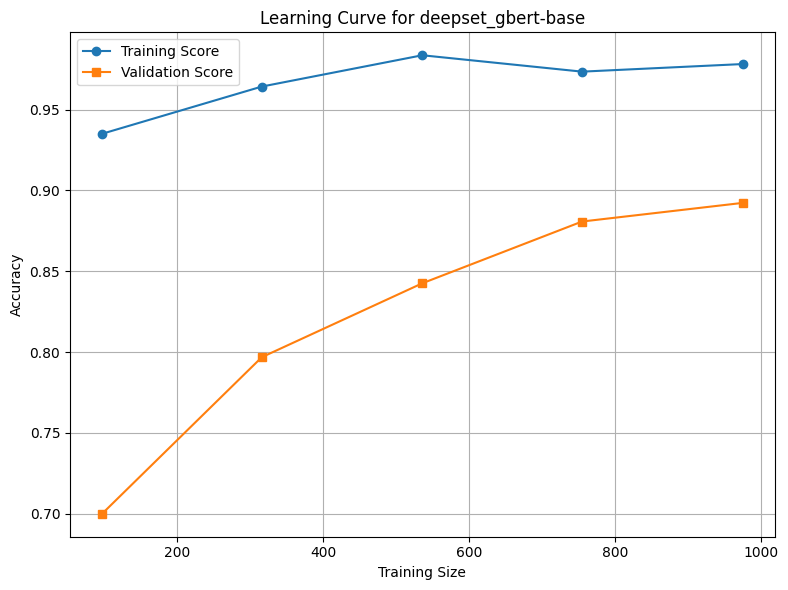


===== Processing Model: aari1995_German_Sentiment =====
  Training size: 97 (10%)
{'eval_loss': 0.868847668170929, 'eval_accuracy': 0.55, 'eval_f1': 0.5328664799253034, 'eval_precision': 0.675, 'eval_recall': 0.55, 'eval_runtime': 0.1725, 'eval_samples_per_second': 115.913, 'eval_steps_per_second': 17.387, 'epoch': 1.0}
{'eval_loss': 0.8681607246398926, 'eval_accuracy': 0.55, 'eval_f1': 0.5328664799253034, 'eval_precision': 0.675, 'eval_recall': 0.55, 'eval_runtime': 0.172, 'eval_samples_per_second': 116.267, 'eval_steps_per_second': 17.44, 'epoch': 2.0}
{'eval_loss': 0.8672448992729187, 'eval_accuracy': 0.55, 'eval_f1': 0.5328664799253034, 'eval_precision': 0.675, 'eval_recall': 0.55, 'eval_runtime': 0.1722, 'eval_samples_per_second': 116.163, 'eval_steps_per_second': 17.424, 'epoch': 3.0}
{'eval_loss': 0.8668339848518372, 'eval_accuracy': 0.55, 'eval_f1': 0.5490043290043289, 'eval_precision': 0.5875, 'eval_recall': 0.55, 'eval_runtime': 0.172, 'eval_samples_per_second': 116.27, 'eva

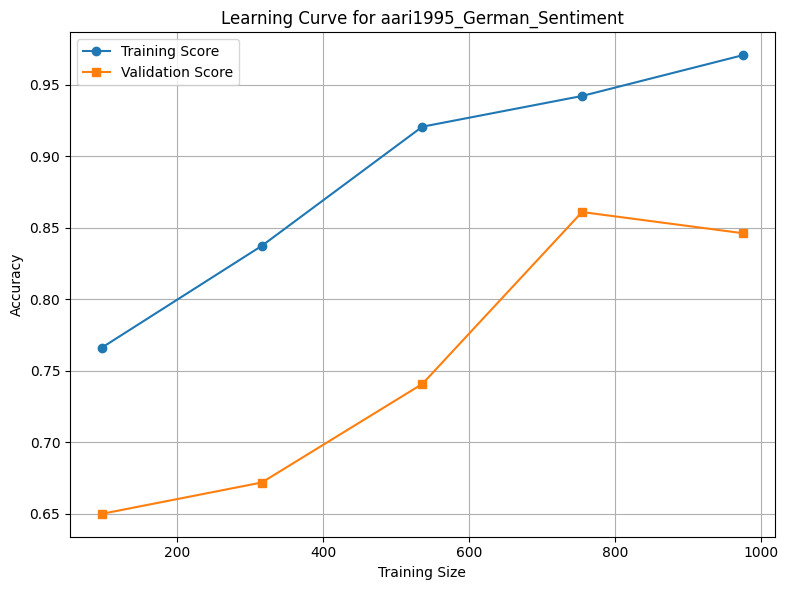


===== Processing Model: oliverguhr_german-sentiment-bert =====
  Training size: 97 (10%)
{'eval_loss': 1.0782978534698486, 'eval_accuracy': 0.35, 'eval_f1': 0.3, 'eval_precision': 0.3107142857142857, 'eval_recall': 0.35, 'eval_runtime': 0.0609, 'eval_samples_per_second': 328.622, 'eval_steps_per_second': 49.293, 'epoch': 1.0}
{'eval_loss': 1.071655035018921, 'eval_accuracy': 0.35, 'eval_f1': 0.3, 'eval_precision': 0.3107142857142857, 'eval_recall': 0.35, 'eval_runtime': 0.0611, 'eval_samples_per_second': 327.575, 'eval_steps_per_second': 49.136, 'epoch': 2.0}
{'eval_loss': 1.0636613368988037, 'eval_accuracy': 0.35, 'eval_f1': 0.3, 'eval_precision': 0.3107142857142857, 'eval_recall': 0.35, 'eval_runtime': 0.0622, 'eval_samples_per_second': 321.724, 'eval_steps_per_second': 48.259, 'epoch': 3.0}
{'eval_loss': 1.0582587718963623, 'eval_accuracy': 0.4, 'eval_f1': 0.37904306220095696, 'eval_precision': 0.45064102564102565, 'eval_recall': 0.4, 'eval_runtime': 0.0607, 'eval_samples_per_secon

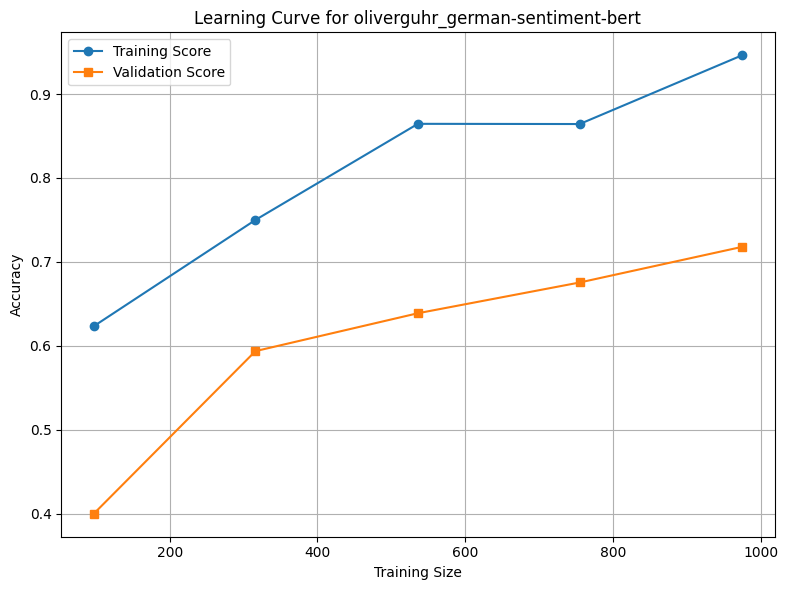


===== Processing Model: lxyuan_distilbert-base-multilingual-cased-sentiments-student =====
  Training size: 97 (10%)
{'eval_loss': 0.8788572549819946, 'eval_accuracy': 0.55, 'eval_f1': 0.532034632034632, 'eval_precision': 0.54375, 'eval_recall': 0.55, 'eval_runtime': 0.0356, 'eval_samples_per_second': 561.93, 'eval_steps_per_second': 84.29, 'epoch': 1.0}
{'eval_loss': 0.8811088800430298, 'eval_accuracy': 0.6, 'eval_f1': 0.5948717948717949, 'eval_precision': 0.59375, 'eval_recall': 0.6, 'eval_runtime': 0.0358, 'eval_samples_per_second': 558.905, 'eval_steps_per_second': 83.836, 'epoch': 2.0}
{'eval_loss': 0.8831034898757935, 'eval_accuracy': 0.6, 'eval_f1': 0.6054166666666667, 'eval_precision': 0.6694444444444445, 'eval_recall': 0.6, 'eval_runtime': 0.0355, 'eval_samples_per_second': 562.865, 'eval_steps_per_second': 84.43, 'epoch': 3.0}
{'eval_loss': 0.8876646757125854, 'eval_accuracy': 0.55, 'eval_f1': 0.54375, 'eval_precision': 0.65, 'eval_recall': 0.55, 'eval_runtime': 0.0353, 'eva

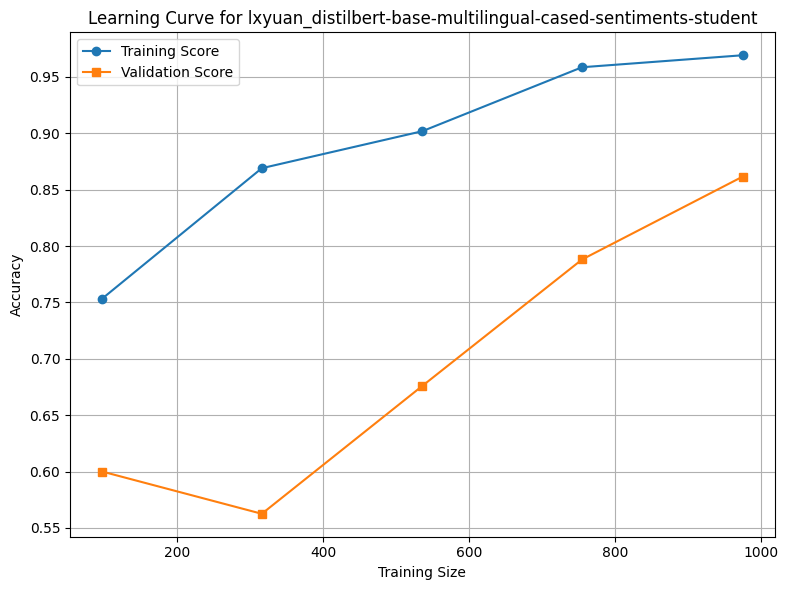


===== Processing Model: nlptown_bert-base-multilingual-uncased-sentiment =====
  Training size: 97 (10%)
{'eval_loss': 0.9661471247673035, 'eval_accuracy': 0.55, 'eval_f1': 0.5503030303030303, 'eval_precision': 0.5549999999999999, 'eval_recall': 0.55, 'eval_runtime': 0.0613, 'eval_samples_per_second': 326.108, 'eval_steps_per_second': 48.916, 'epoch': 1.0}
{'eval_loss': 0.9628657102584839, 'eval_accuracy': 0.55, 'eval_f1': 0.5503030303030303, 'eval_precision': 0.5549999999999999, 'eval_recall': 0.55, 'eval_runtime': 0.0618, 'eval_samples_per_second': 323.884, 'eval_steps_per_second': 48.583, 'epoch': 2.0}
{'eval_loss': 0.9537500143051147, 'eval_accuracy': 0.55, 'eval_f1': 0.5503030303030303, 'eval_precision': 0.5549999999999999, 'eval_recall': 0.55, 'eval_runtime': 0.0615, 'eval_samples_per_second': 325.02, 'eval_steps_per_second': 48.753, 'epoch': 3.0}
{'eval_loss': 0.9494578242301941, 'eval_accuracy': 0.6, 'eval_f1': 0.6, 'eval_precision': 0.61875, 'eval_recall': 0.6, 'eval_runtime'

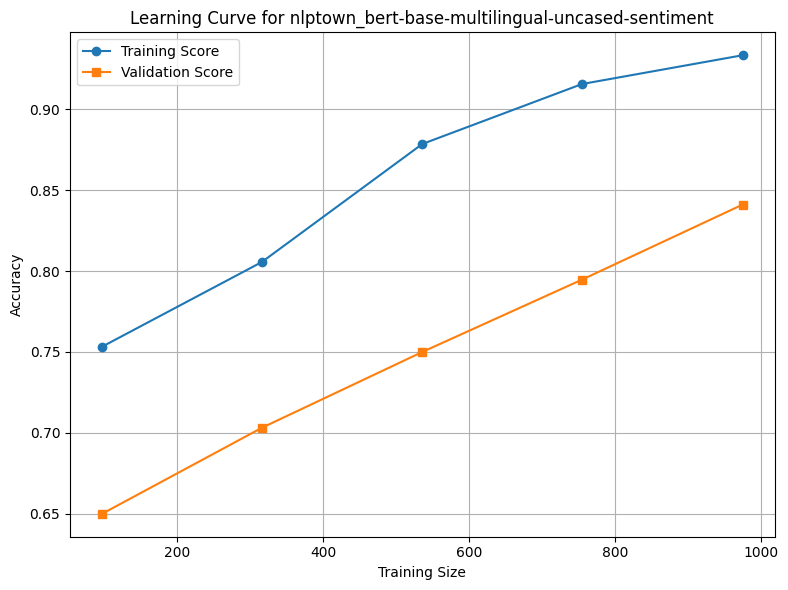


===== Processing Model: distilbert-base-german-cased =====
  Training size: 97 (10%)
{'eval_loss': 0.7649049758911133, 'eval_accuracy': 0.7, 'eval_f1': 0.6987179487179487, 'eval_precision': 0.7020833333333333, 'eval_recall': 0.7, 'eval_runtime': 0.0354, 'eval_samples_per_second': 565.548, 'eval_steps_per_second': 84.832, 'epoch': 1.0}
{'eval_loss': 0.759922981262207, 'eval_accuracy': 0.7, 'eval_f1': 0.6987179487179487, 'eval_precision': 0.7020833333333333, 'eval_recall': 0.7, 'eval_runtime': 0.0372, 'eval_samples_per_second': 537.449, 'eval_steps_per_second': 80.617, 'epoch': 2.0}
{'eval_loss': 0.7589675188064575, 'eval_accuracy': 0.75, 'eval_f1': 0.75, 'eval_precision': 0.75, 'eval_recall': 0.75, 'eval_runtime': 0.0345, 'eval_samples_per_second': 579.224, 'eval_steps_per_second': 86.884, 'epoch': 3.0}
{'eval_loss': 0.7663771510124207, 'eval_accuracy': 0.7, 'eval_f1': 0.7015151515151514, 'eval_precision': 0.70875, 'eval_recall': 0.7, 'eval_runtime': 0.0343, 'eval_samples_per_second': 

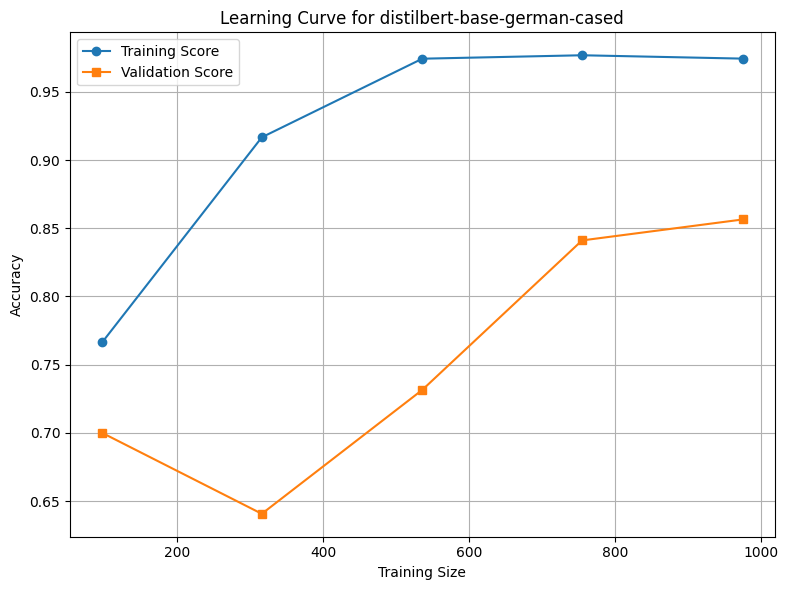


===== Processing Model: xlm-roberta-base =====
  Training size: 97 (10%)
{'eval_loss': 0.9817066192626953, 'eval_accuracy': 0.5, 'eval_f1': 0.45194444444444437, 'eval_precision': 0.5, 'eval_recall': 0.5, 'eval_runtime': 0.0711, 'eval_samples_per_second': 281.343, 'eval_steps_per_second': 42.201, 'epoch': 1.0}
{'eval_loss': 0.9788718223571777, 'eval_accuracy': 0.5, 'eval_f1': 0.45194444444444437, 'eval_precision': 0.5, 'eval_recall': 0.5, 'eval_runtime': 0.0709, 'eval_samples_per_second': 282.039, 'eval_steps_per_second': 42.306, 'epoch': 2.0}
{'eval_loss': 0.9709388613700867, 'eval_accuracy': 0.55, 'eval_f1': 0.49375, 'eval_precision': 0.6944444444444444, 'eval_recall': 0.55, 'eval_runtime': 0.0708, 'eval_samples_per_second': 282.476, 'eval_steps_per_second': 42.371, 'epoch': 3.0}
{'eval_loss': 0.9648523330688477, 'eval_accuracy': 0.55, 'eval_f1': 0.5266666666666666, 'eval_precision': 0.575, 'eval_recall': 0.55, 'eval_runtime': 0.0718, 'eval_samples_per_second': 278.719, 'eval_steps_p

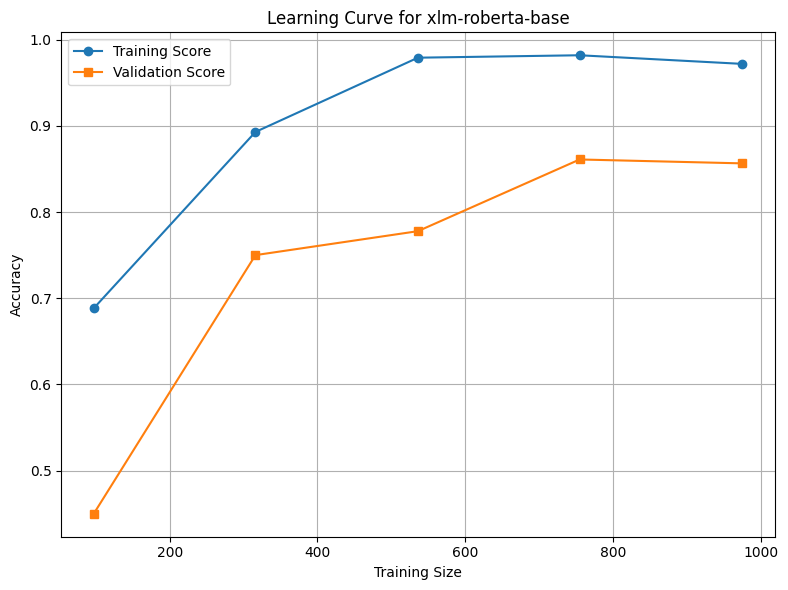


===== Processing Model: ssary_XLM-RoBERTa-German-sentiment =====
  Training size: 97 (10%)
{'eval_loss': 0.7094624638557434, 'eval_accuracy': 0.55, 'eval_f1': 0.5367099567099567, 'eval_precision': 0.5360714285714285, 'eval_recall': 0.55, 'eval_runtime': 0.0609, 'eval_samples_per_second': 328.386, 'eval_steps_per_second': 49.258, 'epoch': 1.0}
{'eval_loss': 0.7062994241714478, 'eval_accuracy': 0.55, 'eval_f1': 0.5367099567099567, 'eval_precision': 0.5360714285714285, 'eval_recall': 0.55, 'eval_runtime': 0.0611, 'eval_samples_per_second': 327.588, 'eval_steps_per_second': 49.138, 'epoch': 2.0}
{'eval_loss': 0.7022347450256348, 'eval_accuracy': 0.55, 'eval_f1': 0.5367099567099567, 'eval_precision': 0.5360714285714285, 'eval_recall': 0.55, 'eval_runtime': 0.0619, 'eval_samples_per_second': 323.076, 'eval_steps_per_second': 48.461, 'epoch': 3.0}
{'eval_loss': 0.6988309025764465, 'eval_accuracy': 0.6, 'eval_f1': 0.5941025641025641, 'eval_precision': 0.5928571428571429, 'eval_recall': 0.6, '

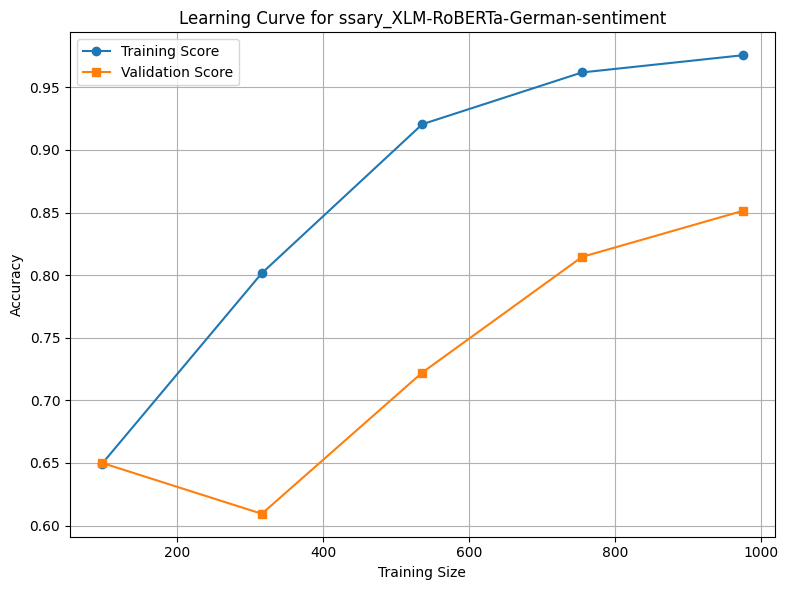

In [ ]:
maissen.generate_learning_curves(texts, labels)